# Metadata
El dataset que se utilizará contiene las siguientes columnas. Este dataset se obtuvo después de una primera ronda de feature engineering.
*  **athlete_id**: id del atleta. Es uno por individuo, se puede repetir si el mismo participa en varias disciplinas o ediciones.        
*  **name**: nombre del atleta.       
*  **sex**: Male ('Masculino') o Female ('Femenino').   
*  **born**: fecha de nacimiento.
*  **height**: altura (cm)
*  **country**: país al que representan.
*  **country_noc**: comité olímpico nacional al que representa. Código de tres letras
*  **medal**: qué medalla obtuvo ('Gold', 'Silver', 'Bronze', NaN)
*  **isTeamSport**: si es un deporte de equipo o no.
*  **event_title**: disciplina que realiza. Ej.: '110m with hurdles, Men'
*  **sport**: deporte que realiza. Ej.: 'Athletics'.
*  **start_date**: fecha en que comenzaron esa edición de los JJOO.
*  **Year**: año de realización de los JJOO.
*  **Edition**: Si los JJOO fueron de verano o invierno.
*  **Q_athlete_participants**: la cantidad de atletas que compiten en esa disciplina. Campo realizado por feature engineering.
*  **Q_country_participants**: la cantidad de atletas que compiten representando a ese país.
*  **Weight**: peso (kg).
*  **posicion**: posición obtenida si es que la disciplina tiene posiciones finales.
*  **athlete_years**: edad (años). Campo realizado por feature engineering.
*  **Medal_Bool**: 1 (obtuvo medalla) o 0 (no obtuvo medalla).
*  **posicion_Norm**: normaliza la posición utilizando la cantidad de participantes. Obteniendo un número entre 0 y 1. Campo obtenido por feature engineering.
*  **rango_athlete_years**: edades pero divididas en rangos (Label encoding). Campo obtenido por feature engineering.
*  **rango_height**: alturas divididas en rangos (Label encoding). Campo obtenido por feature engineering.
*  **rango_Weight**: pesos divididos en rangos (Label encoding). Campo obtenido por feature engineering.

# Data acquisition


## Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Importar librerías
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import missingno as msno 
import plotly.express as px 

from math import sqrt 

# Modelos de regresión
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.metrics import mean_squared_error, r2_score, precision_recall_curve, average_precision_score
from sklearn.metrics import balanced_accuracy_score
# Modelos de clasificación
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn import svm
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Balanceo de datos
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

# Codificación de variables categóricas
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Detección de anomalías
from sklearn.ensemble import IsolationForest 

# Descarga de datos
import urllib.request 

# Evaluación de modelos de clasificación
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve 

# Escalamiento de datos
from sklearn.preprocessing import StandardScaler

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Optimización de hiperparámetros
!pip install hyperopt 
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp, space_eval
from hyperopt.pyll import scope
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score


# Definición de función de puntuación
from sklearn.metrics import make_scorer

# Otros
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Cleaning

Se usaran archivos CSV obtenidos de:

https://www.kaggle.com/datasets/josephcheng123456/olympic-historical-dataset-from-olympediaorg?datasetId=2379197&select=Olympic_Games_Medal_Tally.csv

In [ ]:
# Cargar los datos en DataFrames con nombres descriptivos
bio_data = pd.read_csv("Olympic_Athlete_Bio.csv")
event_data = pd.read_csv("Olympic_Athlete_Event_Results.csv")
result_data=pd.read_csv("Olympic_Results.csv")

# Fusionar los DataFrames
merged_data = pd.merge(bio_data, event_data, on='athlete_id', how='outer')
merged_data=pd.merge(merged_data, result_data, on="result_id",how = 'outer')

# Renombrar la columna "country_noc_x" a "country_noc"
merged_data.rename(columns={'country_noc_x': 'country_noc'}, inplace=True)

# Eliminar columnas innecesarias
merged_data.drop(['country_noc_y'], axis='columns', inplace=True)

In [ ]:
merged_data.head()

,athlete_id,name,sex,born,height,weight,country,country_noc,description,special_notes,...,sport_y,sport_url,result_location,result_participants,result_format,result_detail,result_description,start_date,end_date,time
0,16809,Károly Teppert,Male,1891-07-20,na,na,Hungary,HUN,Károly Teppert started competing in cycling in...,na,...,Cycling Road,/editions/6/sports/CRD,"Stockholms Olympiastadion, Stockholm",123 from 16 countries,315.385 km. (196.0 miles) individual time trial.,na,The race was a mammoth time trial of over 315 ...,1912-07-07,na,02:00
1,16766,Martin Sæterhaug,Male,1882-08-13,na,na,Norway,NOR,na,Brother of Johan Sæterhaug Listed in Olympians...,...,Cycling Road,/editions/6/sports/CRD,"Stockholms Olympiastadion, Stockholm",123 from 16 countries,315.385 km. (196.0 miles) individual time trial.,na,The race was a mammoth time trial of over 315 ...,1912-07-07,na,02:00
2,17135,George Watson,Male,1890-02-26,na,na,Canada,CAN,na,na,...,Cycling Road,/editions/6/sports/CRD,"Stockholms Olympiastadion, Stockholm",123 from 16 countries,315.385 km. (196.0 miles) individual time trial.,na,The race was a mammoth time trial of over 315 ...,1912-07-07,na,02:00
3,13683,Fridrihs Bošs,Male,1887-02-07,na,na,Russian Federation,RUS,na,na,...,Cycling Road,/editions/6/sports/CRD,"Stockholms Olympiastadion, Stockholm",123 from 16 countries,315.385 km. (196.0 miles) individual time trial.,na,The race was a mammoth time trial of over 315 ...,1912-07-07,na,02:00
4,15610,Frank Meissner,Male,1894-07-19,na,na,United States,USA,Frank Meissner was from Michigan and represent...,na,...,Cycling Road,/editions/6/sports/CRD,"Stockholms Olympiastadion, Stockholm",123 from 16 countries,315.385 km. (196.0 miles) individual time trial.,na,The race was a mammoth time trial of over 315 ...,1912-07-07,na,02:00


In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314907 entries, 0 to 314906
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   athlete_id           314907 non-null  int64  
 1   name                 314907 non-null  object 
 2   sex                  314907 non-null  object 
 3   born                 314907 non-null  object 
 4   height               314907 non-null  object 
 5   weight               314907 non-null  object 
 6   country              314907 non-null  object 
 7   country_noc          314907 non-null  object 
 8   description          314907 non-null  object 
 9   special_notes        314907 non-null  object 
 10  edition_x            314907 non-null  object 
 11  edition_id_x         314907 non-null  int64  
 12  sport_x              314907 non-null  object 
 13  event                314907 non-null  object 
 14  result_id            314907 non-null  int64  
 15  athlete          

La salida que proporcionaste es la descripción del DataFrame:

* Int64Index: el DataFrame tiene 314907 filas.
* Data columns (total 32 columns): el DataFrame tiene 32 columnas en total.
Column lista los nombres de las columnas.
* Los datos nulos no aparecen aca, poorque figuran como string "na"

In [ ]:
# Renombrar columnas
merged_data.rename(columns={'edition_y':'edition','edition_id_x':'edition_id','sport_y':'sport'}, inplace=True)

# Separar columnas 'Q_athlete_participants', '_', 'Q_country_participants' y '__' a partir de la columna 'result_participants'
merged_data[['Q_athlete_participants','_','Q_country_participants','__']]=merged_data.result_participants.str.split(" ",4,expand=True)
                                                                                                                    
# Reemplazar 'na' por NaN en todo el DataFrame
merged_data.replace('na',np.nan, inplace=True)

# Separar columnas 'Year' y 'Edition' a partir de la columna 'edition'
merged_data[['Year','Edition']]=merged_data.edition.str.split(" ",1,expand=True)

# Reemplazar ',' y ', ' en la columna 'weight' por '-' y ',' respectivamente
merged_data["weight"]= merged_data["weight"].replace(", ","-",regex= True)
merged_data["weight"]= merged_data["weight"].replace(",",".",regex= True)

# Separar columnas 'p1' y 'p2' a partir de la columna 'weight'
merged_data[['p1','p2']] = merged_data.weight.str.split(pat="-",expand=True)

# Reemplazar NaN en 'p2' con el valor de 'p1'
merged_data["p2"]= merged_data["p2"].fillna(value=np.nan)
merged_data["p2"].fillna(merged_data["p1"], inplace=True)

# Convertir a float las columnas 'p1', 'p2', 'height', 'Q_athlete_participants' y 'Q_country_participants'
merged_data[["p1","p2","height","Q_athlete_participants","Q_country_participants","Year"]] = merged_data[["p1","p2","height","Q_athlete_participants","Q_country_participants","Year"]].astype(float)

# Calcular la media de 'p1' y 'p2' y asignar el resultado a una nueva columna 'Weight'
merged_data["Weight"]=(merged_data['p1']+merged_data['p2'])/2

# Separar columna 'posicion' en dos columnas 'posicion' y 'rest'
merged_data[['posicion','rest']] = merged_data.pos.str.split(" ",1,expand=True)

# Eliminar columnas que no se utilizarán
merged_data.drop(['edition_x',"edition_id_y","sport_x","event","description","special_notes","event","sport_url",'result_format', 'result_detail',
       'result_description', 'end_date', 'time',"result_id","edition_id",'athlete','_',"__","result_participants","edition","result_location",'rest','weight','pos','p1','p2'], axis = 'columns', inplace=True)


In [ ]:
# Rellenar valores NaN en la columna 'born' con 'nan'
merged_data["born"]= merged_data["born"].fillna(value='nan')

# Elimina valores que contenga los valores de la lista 'discard' en la columna 'born'
discard = ['or','born','circa','in','nan']
data= merged_data[~merged_data.born.str.contains('|'.join(discard))]

# Se convierten las columnas 'start_date' y 'born' de formato string a formato datetime
data['start_date'] =  pd.to_datetime(data['start_date'], format="%Y-%m-%d")
data['born'] =  pd.to_datetime(data['born'], format="%Y-%m-%d")

# Se calcula la edad de los atletas en años y se agrega una nueva columna 'athlete_years'
data['athlete_years']=(((data['start_date']-data['born'])/ np.timedelta64(1, 'Y'))//1)

# Se reemplaza el signo "=" en la columna 'posicion' con una cadena vacía
data["posicion"]= data["posicion"].replace("=","",regex= True)

In [ ]:
data.head()

,athlete_id,name,sex,born,height,country,country_noc,medal,isTeamSport,event_title,sport,start_date,Q_athlete_participants,Q_country_participants,Year,Edition,Weight,posicion,athlete_years
0,16809,Károly Teppert,Male,1891-07-20,NaN,Hungary,HUN,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,20.0
1,16766,Martin Sæterhaug,Male,1882-08-13,NaN,Norway,NOR,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,29.0
2,17135,George Watson,Male,1890-02-26,NaN,Canada,CAN,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,78,22.0
3,13683,Fridrihs Bošs,Male,1887-02-07,NaN,Russian Federation,RUS,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,25.0
4,15610,Frank Meissner,Male,1894-07-19,NaN,United States,USA,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,70,17.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308866 entries, 0 to 314906
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   athlete_id              308866 non-null  int64         
 1   name                    308866 non-null  object        
 2   sex                     308866 non-null  object        
 3   born                    308866 non-null  datetime64[ns]
 4   height                  227908 non-null  float64       
 5   country                 308866 non-null  object        
 6   country_noc             308866 non-null  object        
 7   medal                   44205 non-null   object        
 8   isTeamSport             308866 non-null  bool          
 9   event_title             308762 non-null  object        
 10  sport                   308762 non-null  object        
 11  start_date              308673 non-null  datetime64[ns]
 12  Q_athlete_participants  308762

In [ ]:
data.Edition.unique()

array(['Summer Olympics', 'Winter Olympics', 'Equestrian Olympics', nan,
       ' Intercalated Games'], dtype=object)

In [ ]:
# Crear una nueva columna llamada "Medal_Bool" que tenga valor 1 si la columna "medal" contiene "Bronze", "Gold" o "Silver", y valor 0 en caso contrario
data['Medal_Bool'] = data["medal"].apply(lambda x: 1 if x=='Bronze' or x =='Gold' or x=='Silver' else 0)

# Reemplazar en la columna "Edition" el valor ' Intercalated Games' por 'Summer Olympics'
data["Edition"]= data["Edition"].replace(' Intercalated Games','Summer Olympics',regex= True)

# Eliminar las filas que tengan en la columna "Edition" el valor 'Equestrian Olympics'
data=data[(data.Edition!='Equestrian Olympics')]

# First Exploratory Data Analysis

## Data understanding

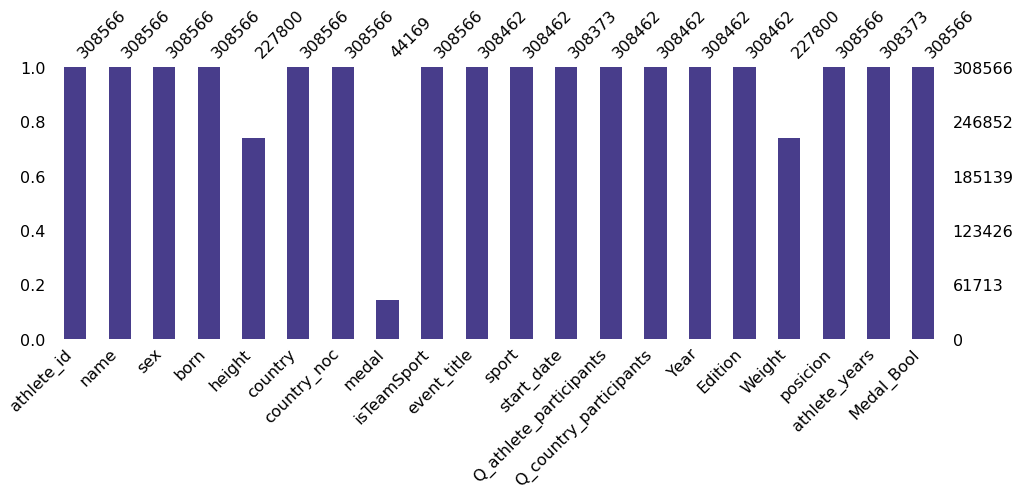

In [ ]:
msno.bar(data, figsize = (16,5),color = "#483D8B")
plt.show()

In [ ]:
for column_name in data.columns:
    unique_values = len(data[column_name].unique())
    print("Feature '{column_name}' has '{unique_values}' unique values".format(column_name = column_name, unique_values=unique_values))

Feature 'athlete_id' has '150472' unique values
Feature 'name' has '147541' unique values
Feature 'sex' has '2' unique values
Feature 'born' has '41983' unique values
Feature 'height' has '95' unique values
Feature 'country' has '695' unique values
Feature 'country_noc' has '231' unique values
Feature 'medal' has '4' unique values
Feature 'isTeamSport' has '2' unique values
Feature 'event_title' has '1486' unique values
Feature 'sport' has '106' unique values
Feature 'start_date' has '924' unique values
Feature 'Q_athlete_participants' has '230' unique values
Feature 'Q_country_participants' has '80' unique values
Feature 'Year' has '39' unique values
Feature 'Edition' has '3' unique values
Feature 'Weight' has '220' unique values
Feature 'posicion' has '199' unique values
Feature 'athlete_years' has '80' unique values
Feature 'Medal_Bool' has '2' unique values


<AxesSubplot:>

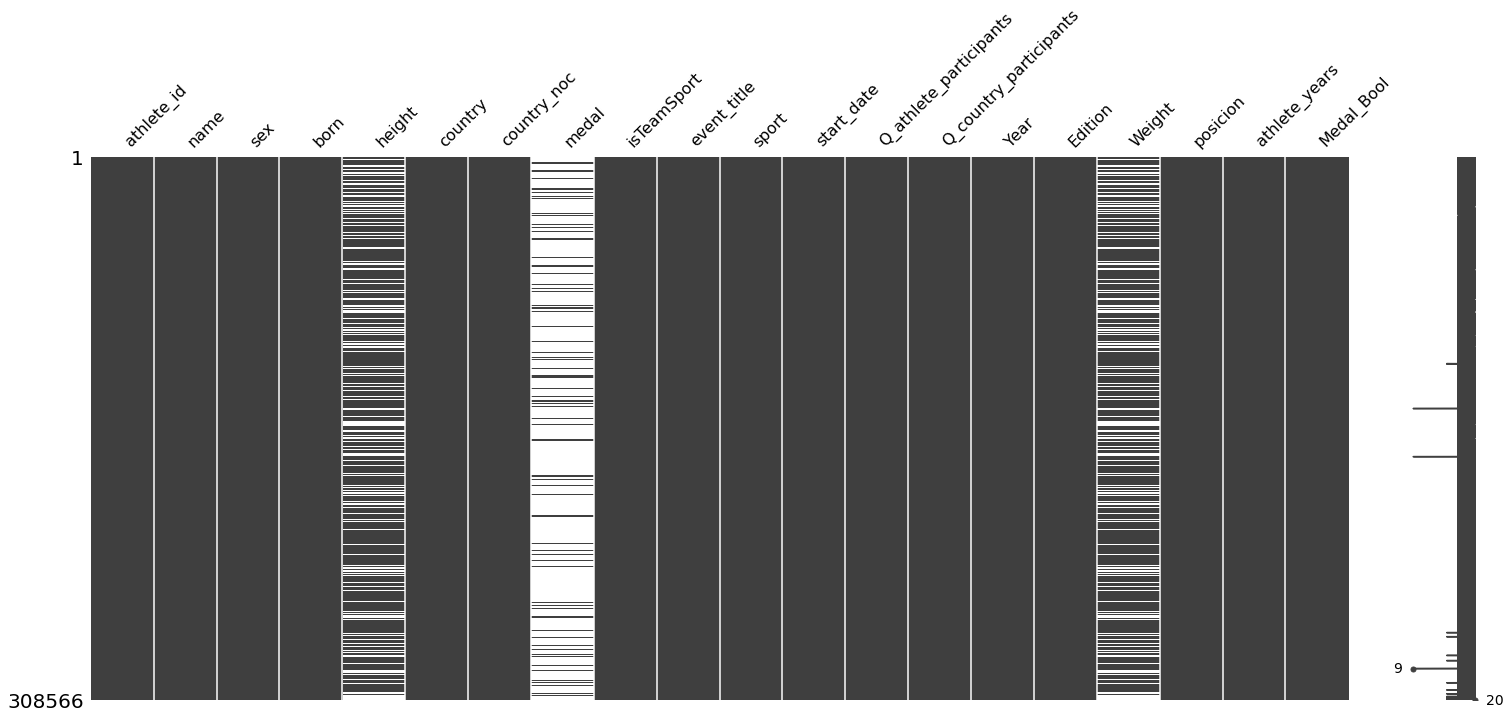

In [ ]:
msno.matrix(data)

In [ ]:
status= ((data.isnull().sum()/271116)*100).sort_values(ascending=False)
status=status[status>0]
status

medal                     97.521725
height                    29.790201
Weight                    29.790201
athlete_years              0.071187
start_date                 0.071187
sport                      0.038360
Q_athlete_participants     0.038360
Edition                    0.038360
Year                       0.038360
event_title                0.038360
Q_country_participants     0.038360
dtype: float64

<AxesSubplot:>

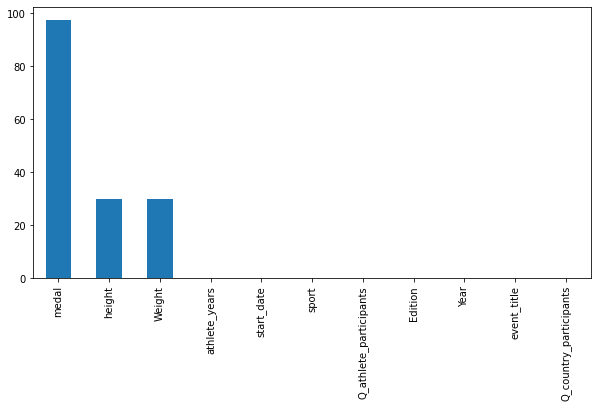

In [ ]:
plt.figure(figsize=(10,5))
status.plot(kind="bar")

In [ ]:
data.duplicated().sum()

1416

In [ ]:
data.describe().style.background_gradient(cmap = "Reds")

,athlete_id,height,Q_athlete_participants,Q_country_participants,Year,Weight,athlete_years,Medal_Bool
count,308566.000000,227800.000000,308462.000000,308462.000000,308462.000000,227800.000000,308373.000000,308566.000000
mean,114954.638081,175.372515,72.751201,20.653403,1981.172332,70.643799,25.630512,0.143143
std,233402.586734,10.476142,58.203957,11.626760,31.109359,14.248236,6.333362,0.350219
min,1.000000,127.000000,0.000000,0.000000,1896.000000,25.000000,10.000000,0.000000
25%,36083.250000,168.000000,34.000000,12.000000,1964.000000,60.000000,22.000000,0.000000
50%,76148.000000,175.000000,55.000000,18.000000,1988.000000,70.000000,25.000000,0.000000
75%,110274.750000,183.000000,88.000000,27.000000,2006.000000,79.000000,28.000000,0.000000
max,22000000.000000,226.000000,312.000000,90.000000,2022.000000,214.000000,97.000000,1.000000


In [ ]:
columns_names = data.columns.values
columns_names

array(['athlete_id', 'name', 'sex', 'born', 'height', 'country',
       'country_noc', 'medal', 'isTeamSport', 'event_title', 'sport',
       'start_date', 'Q_athlete_participants', 'Q_country_participants',
       'Year', 'Edition', 'Weight', 'posicion', 'athlete_years',
       'Medal_Bool'], dtype=object)

In [ ]:
var_cont=['athlete_years', 'height', 'Weight','Q_athlete_participants','Q_country_participants', 'athlete_years']
var_cat=['athlete_id', 'name', 'sex', 'born', 'country',
       'country_noc', 'medal', 'isTeamSport', 'event_title', 'sport',
       'start_date', 'Year', 'Edition', 'posicion', 'Medal_Bool']

In [ ]:
data.head(5)

,athlete_id,name,sex,born,height,country,country_noc,medal,isTeamSport,event_title,sport,start_date,Q_athlete_participants,Q_country_participants,Year,Edition,Weight,posicion,athlete_years,Medal_Bool
0,16809,Károly Teppert,Male,1891-07-20,NaN,Hungary,HUN,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,20.0,0
1,16766,Martin Sæterhaug,Male,1882-08-13,NaN,Norway,NOR,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,29.0,0
2,17135,George Watson,Male,1890-02-26,NaN,Canada,CAN,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,78,22.0,0
3,13683,Fridrihs Bošs,Male,1887-02-07,NaN,Russian Federation,RUS,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,DNF,25.0,0
4,15610,Frank Meissner,Male,1894-07-19,NaN,United States,USA,NaN,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,NaN,70,17.0,0


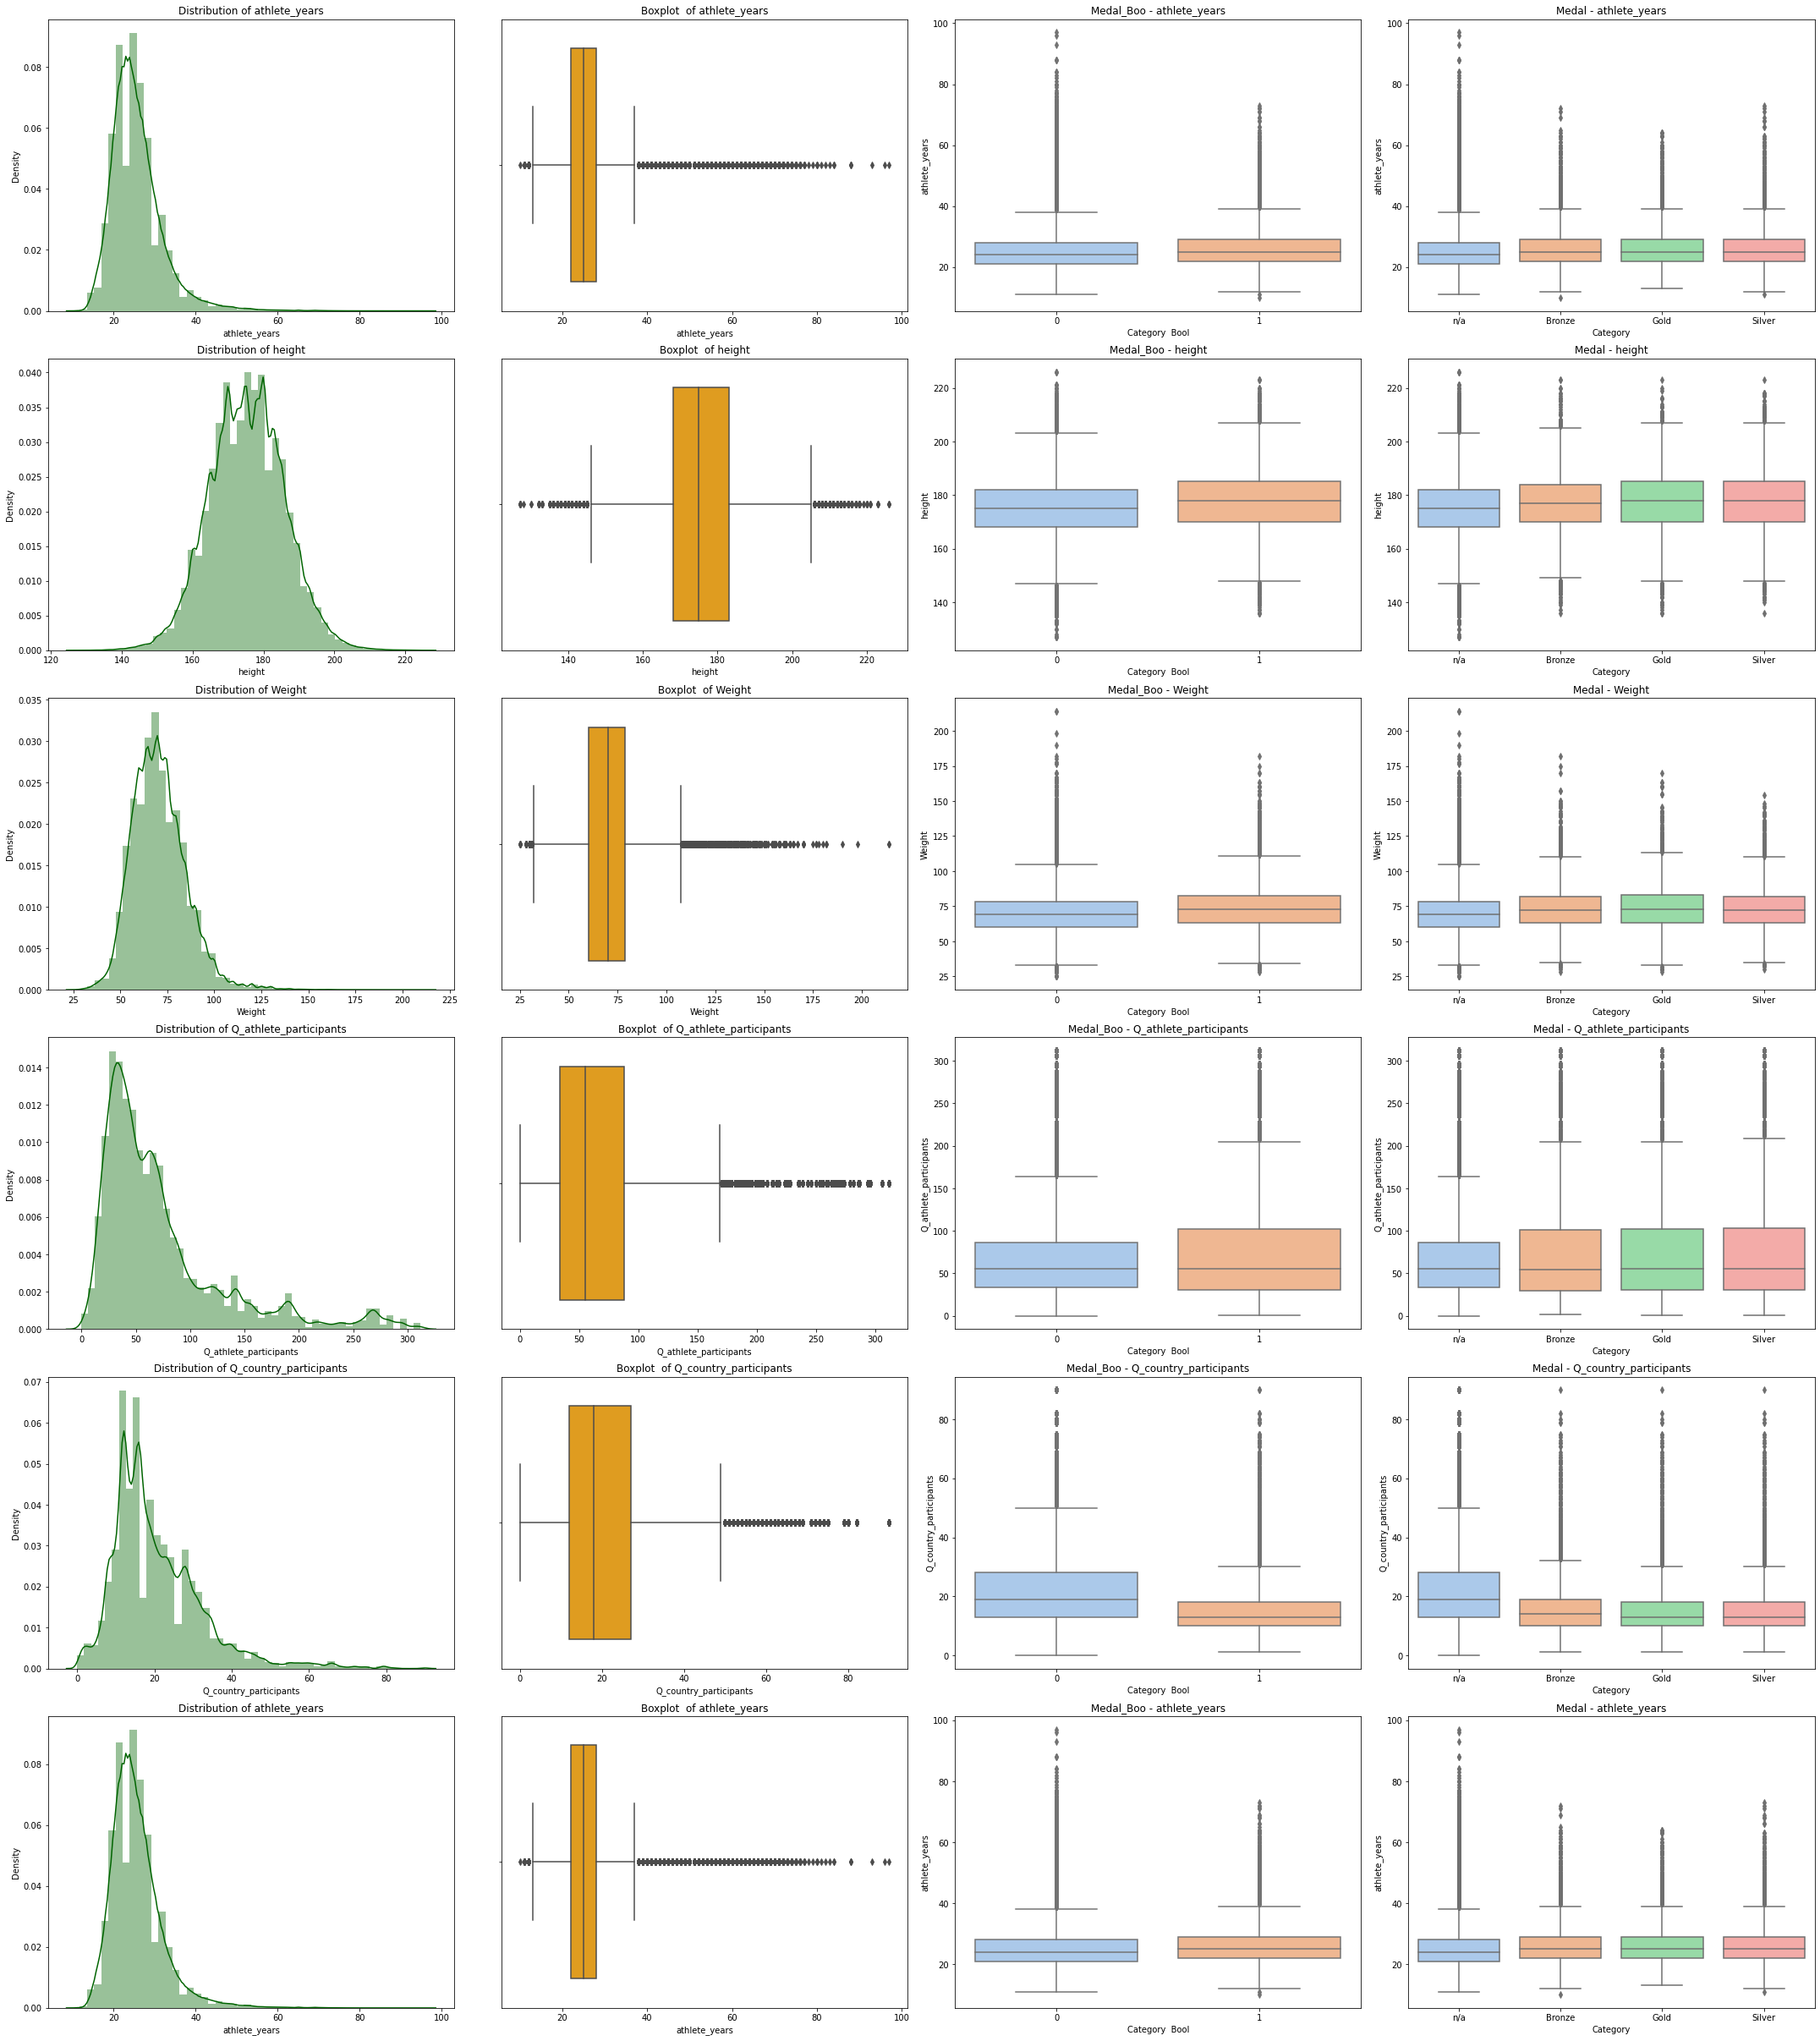

In [ ]:
data['medal'].fillna('n/a', inplace=True)
fig,ax = plt.subplots(len(var_cont),4,figsize=(30,35))
for index,i in enumerate(var_cont):
    sns.set_palette("pastel")
    sns.distplot(data[i],ax=ax[index,0],color='darkgreen')
    ax[index,0].set_title('Distribution of {name}'.format(name=i))
    sns.boxplot(data[i],ax=ax[index,1],color='orange')
    ax[index,1].set_title(f'Boxplot  of {i}')  
    sns.boxplot(data=data,ax=ax[index,2],y=i,x='Medal_Bool')
    ax[index,2].set_xlabel('Category  Bool')
    ax[index,2].set_title(f'Medal_Boo - {i}')
    sns.boxplot(data=data,ax=ax[index,3],y=i,x='medal')
    ax[index,3].set_xlabel('Category')  
    ax[index,3].set_title(f'Medal - {i}')  
fig.tight_layout()
fig.subplots_adjust(top=0.95)

In [ ]:
data.describe(include=['object','bool']).T

,count,unique,top,freq
name,308566,147541,Tait McKenzie,58
sex,308566,2,Male,219623
country,308566,695,United States,22613
country_noc,308566,231,USA,22617
medal,308566,4,n/a,264397
isTeamSport,308566,2,False,190364
event_title,308462,1485,"Football, Men",7618
sport,308462,105,Athletics,46486
Edition,308462,2,Summer Olympics,247369
posicion,308566,199,5,22159


In [ ]:
data["athlete_id"].duplicated().sum()

158094

In [ ]:
# Eliminar las filas duplicadas por la columna 'athlete_id' y agrupar por 'sex' para contar el número de deportistas por sexo
deportistas_x_sexo= data.drop_duplicates(['athlete_id'], keep='first').groupby(['sex']).agg({'sex':'count'}).rename({'sex': 'Cantidad'}, axis=1).reset_index()

In [ ]:
fig = px.pie(
    deportistas_x_sexo, values='Cantidad', names="sex", hole=0.5
)
fig.update_layout(width= 1000, height=600, title='Canitdad de deportistas por sexo')
fig.show()

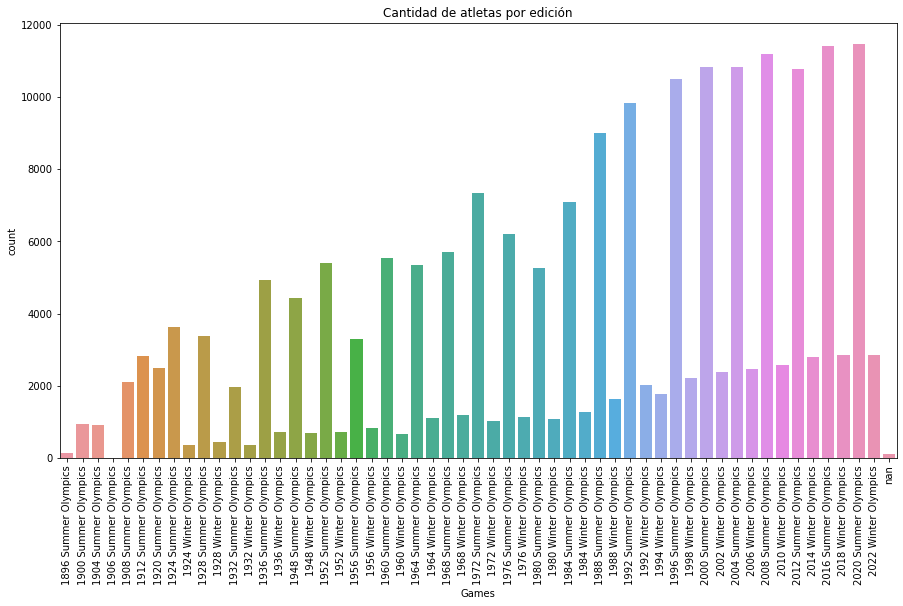

In [ ]:
data["Year_1"]=data["Year"].fillna(0)
data["Games"]=(data["Year_1"].astype(int)).astype(str)+" "+data["Edition"]
data["Games"]=data["Games"].astype(str)

# Eliminar las filas duplicadas según la columna 'athlete_id' y 'Games' para obtener el número de atletas por edición
deportistas_x_game= data.drop_duplicates(['athlete_id',"Games"], keep='first')

plt.figure(figsize=(15,8))
ax = sns.countplot(data=deportistas_x_game, x='Games', order=np.sort(deportistas_x_game['Games'].unique()))
plt.title('Cantidad de atletas por edición')
text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

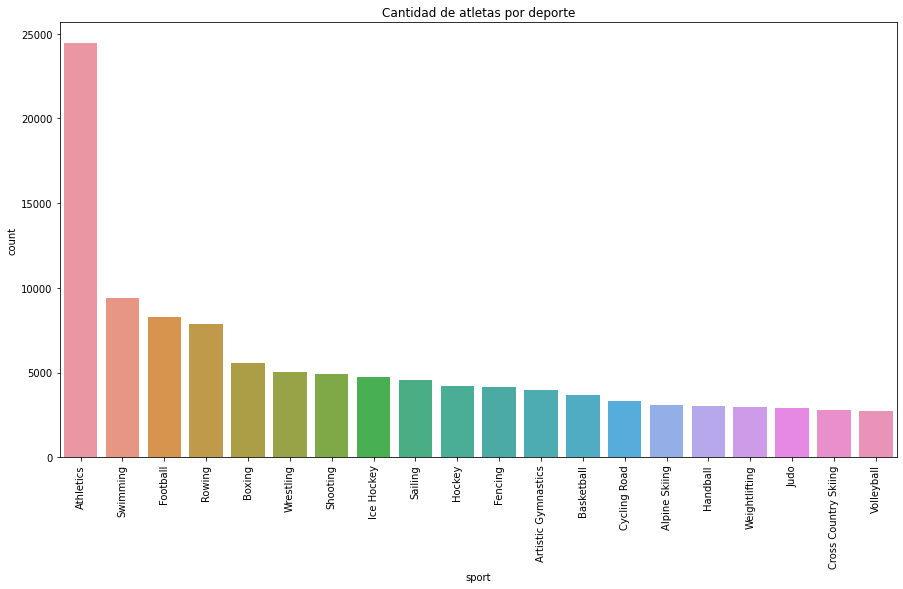

In [ ]:
# Eliminar las filas duplicadas según la columna 'athlete_id' y 'sport' para obtener el número de atletas por deporte
deportistas_x_deporte= data.drop_duplicates(['athlete_id',"sport"], keep='first')
order=deportistas_x_deporte['sport'].value_counts()

plt.figure(figsize=(15,8))
ax = sns.countplot(data=deportistas_x_deporte, x='sport', order=deportistas_x_deporte['sport'].value_counts().index[0:20])
plt.title('Cantidad de atletas por deporte')
text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

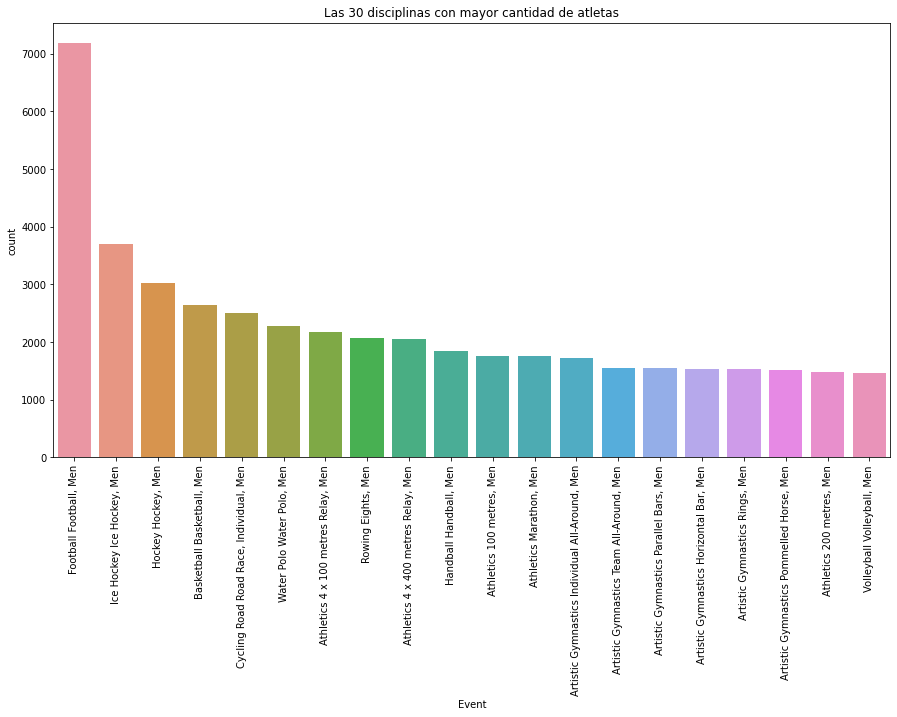

In [ ]:
data['Event']=data['sport']+' '+data['event_title']

# Eliminar las filas duplicadas según la columna 'athlete_id' y 'Event' para obtener el número de atletas por evento
deportistas_x_evento= data.drop_duplicates(['athlete_id',"Event"], keep='first')

plt.figure(figsize=(15,8))
ax = sns.countplot(data=deportistas_x_evento, x='Event', order=deportistas_x_evento['Event'].value_counts().index[0:20])
plt.title('Las 30 disciplinas con mayor cantidad de atletas')
text = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

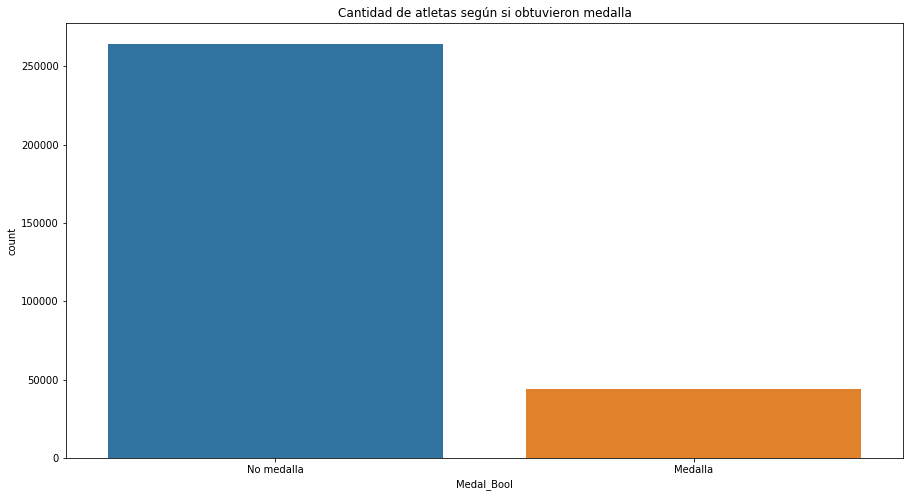

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data=data, x='Medal_Bool')
plt.title('Cantidad de atletas según si obtuvieron medalla')
text = ax.set_xticklabels(labels=['No medalla', 'Medalla'])
plt.show()

In [ ]:
# Agrupamos Medal_Bool para obtener el número de atletas que han obtenido o no medallas
medallistas= data.groupby(['Medal_Bool']).agg({'Medal_Bool':'count'}).rename({'Medal_Bool': 'Cantidad'}, axis=1).reset_index()

fig = px.pie(
    medallistas, values='Cantidad', names="Medal_Bool"
)
fig.update_layout(width= 1000, height=600, title='Medallistas vs No Medallistas')
fig.show()

In [ ]:
var_cat=['athlete_id', 'name', 'sex', 'born', 'country',
       'country_noc', 'medal', 'isTeamSport', 'event_title', 'sport',
       'start_date', 'Year', 'Edition', 'posicion', 'Medal_Bool']

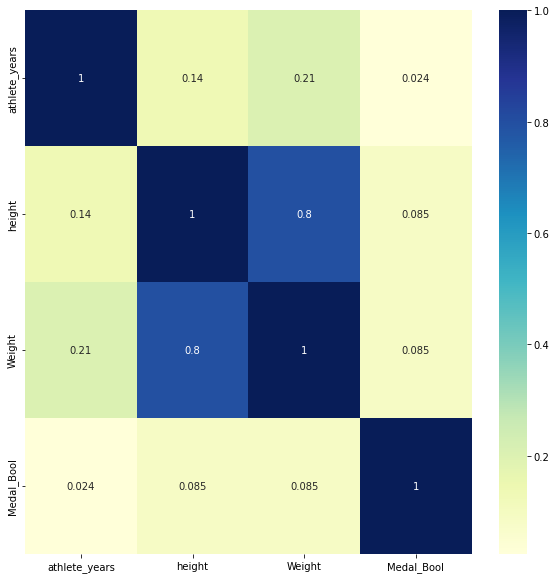

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
dataplot = sns.heatmap(data[['athlete_years', 'height', 'Weight', 'Medal_Bool']].corr(), cmap="YlGnBu", annot=True)

In [ ]:
correlation = data.corr()
print(correlation['Medal_Bool'].sort_values(ascending = False),'\n')

Medal_Bool                1.000000
isTeamSport               0.228559
height                    0.085417
Weight                    0.084905
Q_athlete_participants    0.040368
athlete_years             0.023870
Year_1                   -0.021592
athlete_id               -0.033741
Year                     -0.034925
Q_country_participants   -0.193767
Name: Medal_Bool, dtype: float64 



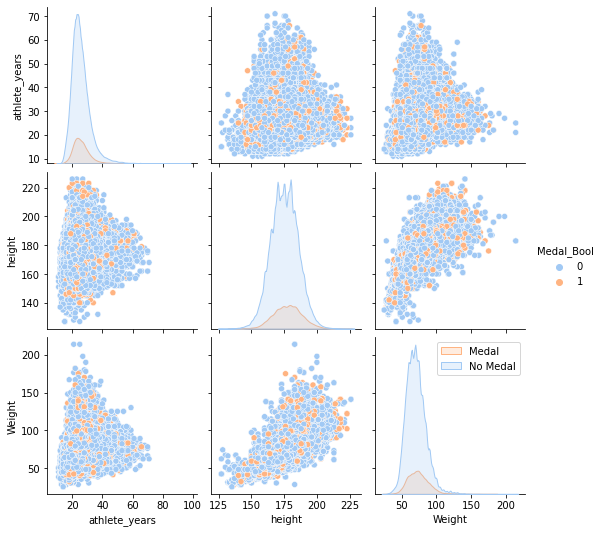

In [ ]:
var_cont_bool=['athlete_years', 'height', 'Weight','Medal_Bool']
ax=sns.pairplot(data[var_cont_bool], hue='Medal_Bool', size=2.5 , kind='scatter')
plt.legend(labels=['Medal', 'No Medal'])
plt.show()

In [ ]:
data["Event"].nunique()

1592

# Data Wrangling

## Handling missing values

Se procede a anular aquellas columnas con datos nulos

In [ ]:
data.drop_duplicates(inplace=True)
data.dropna(axis='rows', subset=['height', 'Weight', 'athlete_years'], inplace=True)
data["medal"].fillna("N_Medal", inplace=True)
data.head(5)

,athlete_id,name,sex,born,height,country,country_noc,medal,isTeamSport,event_title,sport,start_date,Q_athlete_participants,Q_country_participants,Year,Edition,Weight,posicion,athlete_years,Medal_Bool
23,16232,Antti Raita,Male,1883-11-15,171.0,Finland,FIN,N_Medal,False,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,Summer Olympics,87.0,6,28.0,0
144,16232,Antti Raita,Male,1883-11-15,171.0,Finland,FIN,N_Medal,True,"Road Race, Team, Men",Cycling Road,1912-07-07,119.0,13.0,1912.0,Summer Olympics,87.0,5,28.0,0
242,43737,Andrzej Socharski,Male,1947-08-31,173.0,Poland,POL,N_Medal,False,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,Summer Olympics,72.0,14,28.0,0
243,42058,Ari Westergård,Male,1948-05-14,170.0,Finland,FIN,N_Medal,False,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,Summer Olympics,64.0,22,28.0,0
244,42855,Sandhu Singh Gurbir,Male,1951-02-20,176.0,India,IND,N_Medal,False,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,Summer Olympics,82.0,56,25.0,0


## OneHotEncoding and LabelEncoder

Se procede a trasformar las columnas sin datos numéricos a datos numéricos para mejor rendimiento del modelo.

In [ ]:
data = pd.get_dummies(data, prefix="isTeamSport", columns=["isTeamSport"])
data = pd.get_dummies(data, prefix="Edition", columns=["Edition"])
data = pd.get_dummies(data, prefix="sex", columns=["sex"])

In [ ]:
label_encoder= LabelEncoder()
data['NOC_Label']=label_encoder.fit_transform(data['country_noc'])

In [ ]:
label_encoder= LabelEncoder()
data['event_title_Label']=label_encoder.fit_transform(data['event_title'])
data['sport_Label']=label_encoder.fit_transform(data['sport'])

In [ ]:
data.head(2)

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,...,Medal_Bool,isTeamSport_False,isTeamSport_True,Edition_Summer Olympics,Edition_Winter Olympics,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label
23,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,...,0,1,0,1,0,0,1,68,752,26
144,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,...,0,0,1,1,0,0,1,68,754,26


In [ ]:
data['posicion']=pd.to_numeric(data['posicion'], downcast='float', errors='coerce')

```
def delet_outliers(dataset,columna): # dataset= el dataset que se va a examinar, columna= nombre de la columna a verificar outliers
  #Creacion de listas de deporte y sexo, y data set vacio
  lista_sex=dataset['sex'].unique()
  lista_sport=dataset['sport'].unique()
  data=pd.DataFrame()
  # Gereacion de bucle para que encuentre y elimine outliers
  for y in lista_sex:
    for x in lista_sport:
      outliers=dataset[(dataset['sex']==y) & (dataset['sport']==x) ]
      Q1=outliers[columna].quantile(0.25)
      Q3=outliers[columna].quantile(0.75)
      IQR=Q3-Q1
      BI_Calculado=(Q1 - 1.5*IQR)
      BS_Calculado=(Q3 + 1.5*IQR)
      df = outliers[(outliers[columna]>=BI_Calculado) & (outliers[columna]<=BS_Calculado)]
      data=pd.concat([data, df])
  return data
```

In [ ]:
data.head(2)

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,...,Medal_Bool,isTeamSport_False,isTeamSport_True,Edition_Summer Olympics,Edition_Winter Olympics,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label
23,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,...,0,1,0,1,0,0,1,68,752,26
144,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,...,0,0,1,1,0,0,1,68,754,26


## IsolationForest

Es una técnica para poder obtener los outliers, dichos datos se eliminarán 

In [ ]:
lista=data[['athlete_years','height','Weight']]

isolation_forest = IsolationForest(contamination=0.05)
isolation_forest.fit(lista)
y_outlier = isolation_forest.predict(lista)
data['is_outlier'] = y_outlier
data=data[data["is_outlier"]==1]
data.drop("is_outlier", axis=1, inplace=True)

In [ ]:
data.event_title.nunique()

950

In [ ]:
data.dropna(axis='rows', subset=['posicion'], inplace=True)

## Interval Cut and LabelEncoder

Se procede a dividir en intervalos datos como el peso, altura y edad del atleta, y luego a encodearlo. De esta manera se convierten datos de naturaleza continua en datos de naturaleza categórica.

In [ ]:
for n in lista:
  data.sort_values(n)
  data[f'rango_{n}']= pd.qcut(data[n], 10)

In [ ]:
data.head(3)

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,...,Edition_Summer Olympics,Edition_Winter Olympics,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label,rango_athlete_years,rango_height,rango_Weight
23,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,...,1,0,0,1,68,752,26,"(27.0, 29.0]","(170.0, 173.0]","(80.0, 87.0]"
144,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,...,1,0,0,1,68,754,26,"(27.0, 29.0]","(170.0, 173.0]","(80.0, 87.0]"
242,43737,Andrzej Socharski,1947-08-31,173.0,Poland,POL,N_Medal,"Skeet, Open",Shooting,1976-07-22,...,1,0,0,1,161,795,57,"(27.0, 29.0]","(170.0, 173.0]","(70.0, 73.0]"


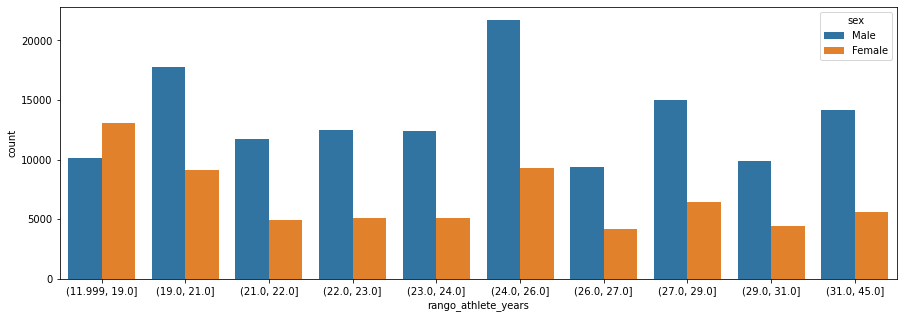

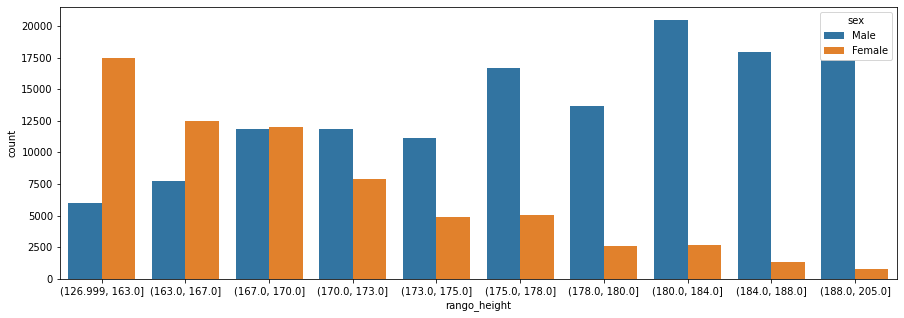

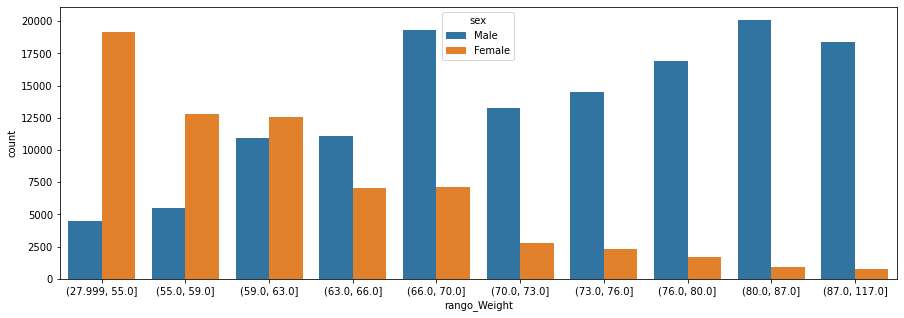

In [ ]:
data['sex'] = 'Female'
data.loc[data['sex_Male'] == 1, 'sex'] = 'Male'

for n in lista:
  fig, axs= plt.subplots(figsize=(15,5))
  sns.countplot(x=f'rango_{n}', hue='sex', data=data)

In [ ]:
data['rango_athlete_years']=label_encoder.fit_transform(data['rango_athlete_years'])
data['rango_height']=label_encoder.fit_transform(data['rango_height'])
data['rango_Weight']=label_encoder.fit_transform(data['rango_Weight'])

In [ ]:
 # Normaliza. Relaciona la posición con la cantidad de participantes. Para poder comparar ediciones con distintas cantidades de participantes.
data['posicion_Norm']=data['posicion']/data['Q_athlete_participants']
maraton_m=data[data['event_title']=='Marathon, Men']
hjump_options= ['High Jump, Men', 'High Jump, Women',] 
hjump=data[data['event_title'].isin(hjump_options)]
hjump.shape

(1158, 31)

In [ ]:
data.head(2)

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,...,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label,rango_athlete_years,rango_height,rango_Weight,sex,posicion_rel
23,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,...,0,1,68,752,26,7,3,8,Male,0.048780
144,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,...,0,1,68,754,26,7,3,8,Male,0.042017


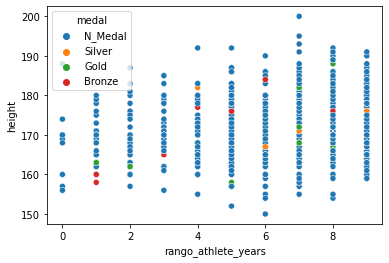

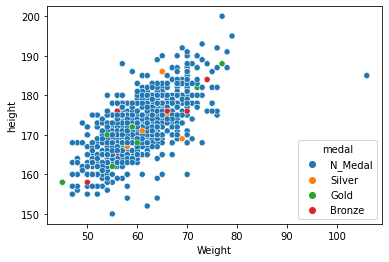

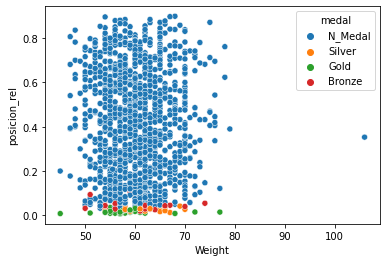

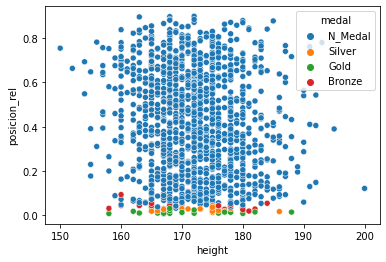

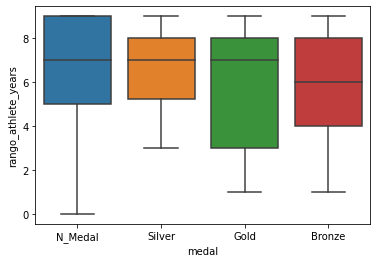

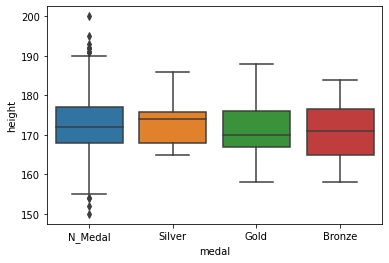

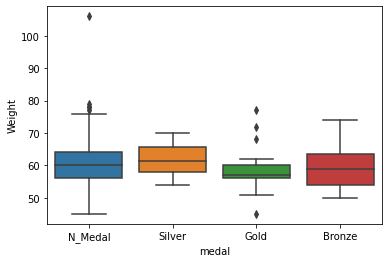

In [ ]:
# Scatterplot of age vs. height, colored by medal
sns.scatterplot(x='rango_athlete_years', y='height', hue='medal', data=maraton_m)
plt.show()
# Scatterplot of weight vs. height, colored by medal
sns.scatterplot(x='Weight', y='height', hue='medal', data=maraton_m)
plt.show()
# Scatterplot of weight vs. position, colored by medal
sns.scatterplot(x='Weight', y='posicion_Norm', hue='medal', data=maraton_m)
plt.show()
# Scatterplot of weight vs. position, colored by medal
sns.scatterplot(x='height', y='posicion_Norm', hue='medal', data=maraton_m)
plt.show()
# Boxplot of age by medal
sns.boxplot(x='medal', y='rango_athlete_years', data=maraton_m)
plt.show()
# Boxplot of height by medal
sns.boxplot(x='medal', y='height', data=maraton_m)
plt.show()
# Boxplot of weight by medal
sns.boxplot(x='medal', y='Weight', data=maraton_m)
plt.show()

## Normalizaciones y Estandarizaciones

In [ ]:
diccionario=['height','Q_athlete_participants', 'Q_country_participants', 'Weight','athlete_years', 'sex_Female', 'NOC_Label','event_title_Label', 'sport_Label']

In [ ]:
for n in diccionario:
    # Normalizar columna y agregar al DataFrame con sufijo "_Norm"
    data[f'{n}_Norm']=(data[n]-data[n].min())/(data[n].max()-data[n].min())
    # Estandarizar columna y agregar al DataFrame con sufijo "_srd"
    data[f'{n}_srd']=(data[n]-data[n].mean())/data[n].std()

In [ ]:
pd.options.display.max_columns = None

In [ ]:
data.head()

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,Q_athlete_participants,Q_country_participants,Year,Weight,posicion,athlete_years,Medal_Bool,isTeamSport_False,isTeamSport_True,Edition_Summer Olympics,Edition_Winter Olympics,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label,rango_athlete_years,rango_height,rango_Weight,sex,posicion_rel,height_Norm,height_srd,Q_athlete_participants_Norm,Q_athlete_participants_srd,Q_country_participants_Norm,Q_country_participants_srd,Weight_Norm,Weight_srd,athlete_years_Norm,athlete_years_srd,sex_Female_Norm,sex_Female_srd,NOC_Label_Norm,NOC_Label_srd,event_title_Label_Norm,event_title_Label_srd,sport_Label_Norm,sport_Label_srd
23,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,87.0,6.0,28.0,0,1,0,1,0,0,1,68,752,26,7,3,8,Male,0.048780,0.564103,-0.457546,0.390323,0.829912,0.168539,-0.515973,0.662921,1.356362,0.484848,0.632291,0.0,-0.706811,0.299559,-0.644814,0.780083,1.084926,0.329114,-0.323799
144,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,119.0,13.0,1912.0,87.0,5.0,28.0,0,0,1,1,0,0,1,68,754,26,7,3,8,Male,0.042017,0.564103,-0.457546,0.377419,0.761556,0.134831,-0.773489,0.662921,1.356362,0.484848,0.632291,0.0,-0.706811,0.299559,-0.644814,0.782158,1.091941,0.329114,-0.323799
242,43737,Andrzej Socharski,1947-08-31,173.0,Poland,POL,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,72.0,14.0,28.0,0,1,0,1,0,0,1,161,795,57,7,3,5,Male,0.205882,0.589744,-0.249723,0.212903,-0.109989,0.426966,1.458313,0.494382,0.148870,0.484848,0.632291,0.0,-0.706811,0.709251,0.785379,0.824689,1.235748,0.721519,0.942586
243,42058,Ari Westergård,1948-05-14,170.0,Finland,FIN,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,64.0,22.0,28.0,0,1,0,1,0,0,1,68,795,57,7,2,3,Male,0.323529,0.551282,-0.561458,0.212903,-0.109989,0.426966,1.458313,0.404494,-0.495126,0.484848,0.632291,0.0,-0.706811,0.299559,-0.644814,0.824689,1.235748,0.721519,0.942586
244,42855,Sandhu Singh Gurbir,1951-02-20,176.0,India,IND,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,82.0,56.0,25.0,0,1,0,1,0,0,1,93,795,57,5,5,8,Male,0.823529,0.628205,0.062011,0.212903,-0.109989,0.426966,1.458313,0.606742,0.953865,0.393939,0.010183,0.0,-0.706811,0.409692,-0.260354,0.824689,1.235748,0.721519,0.942586


# Desarrollo de los modelos de ML

## Modelos de regresión
En un primer momento, intentaremos desarrollar un modelo de regresión, utilizando como variable objetivo la posición obtenida (previamente normalizada con la cantidad de participantes). Para lo siguiente utilizaremos: regresión lineal, con sus variantes de Ridge y Lasso, árboles de decisión, random forests y Gradient Boosting.

In [ ]:
# Extract the features and target
X = maraton_m[['height', 'Weight', 'athlete_years']]
y = maraton_m['posicion_Norm']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Random Forest Model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Random Forest Test RMSE : ", rmse)
print("Random Forest Test R-squared : ", r2)

# Decision Tree Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Decision Tree Test RMSE : ", rmse)
print("Decision Tree Test R-squared : ", r2)

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression Test RMSE : ", rmse)
print("Linear Regression Test R-squared : ", r2)

# Lasso Model
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Lasso Test RMSE : ", rmse)
print("Lasso Test R-squared : ", r2)

# Ridge Model
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Ridge Test RMSE : ", rmse)
print("Ridge Test R-squared : ", r2)

# Gradient Boosting Model
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Gradient Boosting Test RMSE : ", rmse)
print("Gradient Boosting Test R-squared : ", r2)


Random Forest Test RMSE :  0.2581004014601578
Random Forest Test R-squared :  -0.21400710153290037
Decision Tree Test RMSE :  0.3529760977337828
Decision Tree Test R-squared :  -1.2705677348015905
Linear Regression Test RMSE :  0.23078798081544233
Linear Regression Test R-squared :  0.02933305136145048
Lasso Test RMSE :  0.23434575569758143
Lasso Test R-squared :  -0.0008247844288276074
Ridge Test RMSE :  0.23078806842213484
Ridge Test R-squared :  0.02933231443453821
Gradient Boosting Test RMSE :  0.23154684533999656
Gradient Boosting Test R-squared :  0.022939167748364575


Estos resultados nos muestran que con estos algoritmos no parece ser posible predecir la posicion de los maratonistas basándose en los datos provistos.

Lo que hace el siguiente código es entrenar distintos modelos para cada disciplina. Por lo tanto itera por cada modelo y por cada disciplina. Estos resultados los carga en un dataframe para poder evaluar cuáles pueden ser más viables. Los resultados para la mayoría fueron malos. En los pocos modelos con buenas métricas podemos inferir que hubo overfitting, ya que la cantidad de atletas en esos deportes eran muy pocos.

In [ ]:
events=data['event_title'].unique()

In [ ]:
models_regression = {'Random Forest': RandomForestRegressor(),
          'Decision Tree': DecisionTreeRegressor(),
          'Linear Regression': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'Gradient Boosting': GradientBoostingRegressor()}
results_df_regr = pd.DataFrame(columns=['event', 'model', 'R-squared', 'RMSE'])

for event in events:
  df_event=data[data['event_title']==f'{event}']
  if len(df_event) < 2:
    continue #skip events that have less than 2 samples
  num_ath = len(df_event)
  # Extract the features and target
  X = df_event[['Weight','height', 'athlete_years','sex_Female', 'sex_Male']]
  y = df_event['posicion_Norm']


  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  for model_name, model in models_regression.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      r2 = r2_score(y_test, y_pred)
      rmse = sqrt(mean_squared_error(y_test, y_pred))
      # Append the results to the DataFrame
      results_df_regr = results_df_regr.append({'event': event, 'model': model_name, 'Q_athletes': num_ath, 'R-squared': r2, 'RMSE': rmse}, ignore_index=True)

In [ ]:
results_df_regr.sort_values('R-squared',ascending=False)

,event,model,R-squared,RMSE,Q_athletes
3043,"Coxless Fours, Men1",Decision Tree,1.000000,0.000000e+00,9.0
3047,"Coxless Fours, Men1",Gradient Boosting,1.000000,4.249697e-07,9.0
3190,"Middleweight (≤73 kilograms), Men",Ridge,0.986764,1.232633e-02,10.0
3188,"Middleweight (≤73 kilograms), Men",Linear Regression,0.984163,1.348332e-02,10.0
3691,"Air Pistol, 10 metres, Team, Mixed",Decision Tree,0.981328,2.500000e-02,13.0
...,...,...,...,...,...
4933,"Welterweight (≤65 kilograms), Women",Decision Tree,NaN,5.476190e-01,2.0
4934,"Welterweight (≤65 kilograms), Women",Linear Regression,NaN,5.476190e-01,2.0
4935,"Welterweight (≤65 kilograms), Women",Lasso,NaN,5.476190e-01,2.0
4936,"Welterweight (≤65 kilograms), Women",Ridge,NaN,5.476190e-01,2.0


Los resultados de esta tabla nos muestran que para la gran mayoría de las disciplinas las métricas fueron decepcionantes. Y aquellas que encabezan la tabla con excelentes métricas se nota que hay sufrido 'Overfitting' por el minúsculo tamaño de la muestra. Pasaremos a los modelos de clasificación.

## Modelos de clasificación por disciplina
En esta sección, cambiamos el enfoque. Dejamos de ver el problema como una regresión, buscando predecir una posición y aplicaremos modelos de clasificación para definir si se puede predecir la obtención de una medalla o no.

In [ ]:
models_classification = {'Logistic Regression': LogisticRegression(C=0.1, class_weight='balanced', max_iter=15),
                         'Decision Trees': DecisionTreeClassifier(criterion='entropy', max_depth=12),
                         'Naive Bayes': GaussianNB(),
                         'Random Forest': RandomForestClassifier(max_depth=12, n_estimators=300),
                         'Gradient Boosting': GradientBoostingClassifier(max_depth=12, min_samples_split=6, n_estimators=300),
                         }
                         
results_df_class = pd.DataFrame(columns=['event', 'model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [ ]:
for event in events:
  df_event=data[data['event_title']==f'{event}']
  if len(df_event['Medal_Bool'].unique()) < 2:
    continue #skip events that have less than 2 classes
  num_ath=len(df_event)
  # Extract the features and target
  X = df_event[['Weight','height', 'athlete_years','sex_Female', 'sex_Male']]
  y = df_event['Medal_Bool']


  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  if len(y_train.unique()) < 2:
    continue #skip events whose train sets have only 1 class
  for model_name, model in models_classification.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      acc = accuracy_score(y_test, y_pred)
      prec = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)


      # Append the results to the DataFrame
      results_df_class = results_df_class.append({'event': event, 'model': model_name, 'Q_athletes': num_ath, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)

In [ ]:
results_df_class.sort_values(['F1-Score','Q_athletes','Precision','Recall','Accuracy'],ascending=False)

,event,model,Accuracy,Precision,Recall,F1-Score,Q_athletes
2941,"Team Sprint, Women",Decision Trees,1.0,1.0,1.0,1.0,45.0
2089,"30 kilometres, Classical, Women",Gradient Boosting,1.0,1.0,1.0,1.0,42.0
2420,"Light-Heavyweight, Greco-Roman (≤85 kilograms)...",Logistic Regression,1.0,1.0,1.0,1.0,40.0
3318,"Alpine Combined, Women",Random Forest,1.0,1.0,1.0,1.0,27.0
3490,"Lightweight, Greco-Roman (≤63 kilograms), Men",Logistic Regression,1.0,1.0,1.0,1.0,20.0
...,...,...,...,...,...,...,...
2204,"Trap, Team, Men",Gradient Boosting,0.0,0.0,0.0,0.0,3.0
3236,"Flyweight, Freestyle (≤50 kilograms), Women",Decision Trees,0.0,0.0,0.0,0.0,3.0
3237,"Flyweight, Freestyle (≤50 kilograms), Women",Naive Bayes,0.0,0.0,0.0,0.0,3.0
3238,"Flyweight, Freestyle (≤50 kilograms), Women",Random Forest,0.0,0.0,0.0,0.0,3.0


## Primera evaluación de modelos

### Evaluación por datos 
* Estandarizados
* Rango
* Normalizado
* Puro

In [ ]:
models= {'Logistic Regression': LogisticRegression(),
                         'Decision Trees': DecisionTreeClassifier(),
                         'Random Forest': RandomForestClassifier(),
                         'Gradient Boosting': GradientBoostingClassifier(),
                         "XGBClassifier":xgb.XGBClassifier()
                         }
results_df_class = pd.DataFrame(columns=['model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

In [ ]:
# Uso de features originales
X = data[['height','Q_athlete_participants','Q_country_participants',"Weight", 'athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = data['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Entrenar y evaluar los modelos usando los datos de prueba

for key, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    results_df_class= results_df_class.append({"Tipo":"Datos_Puros",'model': key, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)

# Uso de features rangos
X = data[['rango_height','Q_athlete_participants','Q_country_participants',"rango_Weight", 'rango_athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = data['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Entrenar y evaluar los modelos usando los datos de prueba
for key, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_df_class = results_df_class.append({"Tipo":"Datos_Rangos",'model': key, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)

# Uso de features normalizados
X = data[['height_Norm','Q_athlete_participants_Norm','Q_country_participants_Norm',"Weight_Norm", 'athlete_years_Norm','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label_Norm', 'event_title_Label_Norm', 'sport_Label_Norm']]
y = data['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Entrenar y evaluar los modelos usando los datos de prueba
for key, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    results_df_class = results_df_class.append({"Tipo":"Datos_Norm",'model': key, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)

# Uso de features estandarizados
X = data[['height_srd','Q_athlete_participants_srd','Q_country_participants_srd',"Weight_srd", 'athlete_years_srd','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label_srd', 'event_title_Label_srd', 'sport_Label_srd']]
y = data['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Entrenar y evaluar los modelos usando los datos de prueba
for key, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    results_df_class = results_df_class.append({"Tipo":"Datos_Std",'model': key, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1-Score': f1}, ignore_index=True)


In [ ]:
results_df_class.sort_values(["model",'Precision','F1-Score','Recall','Accuracy'],ascending=False) 

,event,model,Accuracy,Precision,Recall,F1-Score,Tipo
9,NaN,XGBClassifier,0.880601,0.802365,0.303757,0.440682,Datos_Rangos
4,NaN,XGBClassifier,0.879289,0.797840,0.295284,0.431039,Datos_Puros
14,NaN,XGBClassifier,0.879289,0.797840,0.295284,0.431039,Datos_Norm
19,NaN,XGBClassifier,0.879289,0.797840,0.295284,0.431039,Datos_Std
2,NaN,Random Forest,0.889464,0.803390,0.378897,0.514938,Datos_Puros
12,NaN,Random Forest,0.889068,0.797451,0.380176,0.514886,Datos_Norm
17,NaN,Random Forest,0.888449,0.794742,0.376978,0.511386,Datos_Std
7,NaN,Random Forest,0.887780,0.768894,0.393605,0.520673,Datos_Rangos
15,NaN,Logistic Regression,0.845299,0.875000,0.001119,0.002235,Datos_Std
0,NaN,Logistic Regression,0.845274,0.857143,0.000959,0.001916,Datos_Puros


* Se puede observar mejores métricas en aquellos datos que contienen rangos

### Cross Validations con StratifiedKFold

In [ ]:
X = data[['rango_height','Q_athlete_participants','Q_country_participants',"rango_Weight", 'rango_athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = data['Medal_Bool']

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

5

In [ ]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
models= {'Logistic Regression': LogisticRegression(),
         'Decision Trees': DecisionTreeClassifier(),
         'Random Forest': RandomForestClassifier(),
         'Gradient Boosting': GradientBoostingClassifier(),
         "XGBClassifier":xgb.XGBClassifier(),
         'lightgbm': lgb.LGBMClassifier(),
                         }

In [ ]:
# Iterar sobre cada modelo
for  key, models in models.items():
  print(key)
  list_ac=[]
  list_f1=[]

  # Iterar sobre cada split
  for i, (train, test) in enumerate(skf.split(X, y)):
    
    # Separar train y test
    X_train_n, y_train_n, X_test_n, y_test_n= X_train, y_train, X_test,y_test

    # Ajustar el modelo y Predicciones
    models.fit(X_train_n, y_train_n)
    pred= models.predict(X_test_n)

    # Calculo del error
    accuracy= accuracy_score(y_true=y_test_n, y_pred= pred)
    print('Iteracion: ',i+1, ' Accuracy:', accuracy)
    f1 = f1_score(y_test_n, pred)
    print('Iteracion: ',i+1, ' F1:', f1)
    list_ac.append(accuracy)
    list_f1.append(f1)
  
  # Calcular la media de las métricas de evaluación
  mean_accuracy = np.mean(list_ac)
  mean_f1 = np.mean(list_f1)

  # Imprimir las métricas de evaluación promedio
  print('Accuracy promedio:', mean_accuracy)
  print('F1 promedio:', mean_f1)
  print('')
  print('-' * 30)
  print('')

Logistic Regression
Iteracion:  1  Accuracy: 0.8447750847919194
Iteracion:  1  F1: 0.0019102196752626554
Iteracion:  2  Accuracy: 0.8447750847919194
Iteracion:  2  F1: 0.0019102196752626554
Iteracion:  3  Accuracy: 0.8447750847919194
Iteracion:  3  F1: 0.0019102196752626554
Iteracion:  4  Accuracy: 0.8447750847919194
Iteracion:  4  F1: 0.0019102196752626554
Iteracion:  5  Accuracy: 0.8447750847919194
Iteracion:  5  F1: 0.0019102196752626554
Accuracy promedio: 0.8447750847919193
F1 promedio: 0.0019102196752626554

------------------------------

Decision Trees
Iteracion:  1  Accuracy: 0.8580199539524175
Iteracion:  1  F1: 0.5542861583896791
Iteracion:  2  Accuracy: 0.8563860074765429
Iteracion:  2  F1: 0.5497865735351183
Iteracion:  3  Accuracy: 0.857425791597554
Iteracion:  3  F1: 0.550394254040128
Iteracion:  4  Accuracy: 0.8550738989428861
Iteracion:  4  F1: 0.5478139966012667
Iteracion:  5  Accuracy: 0.8559403857103953
Iteracion:  5  F1: 0.5478983761945458
Accuracy promedio: 0.85656

Los mejores promedios en f1 fueron:
* DecisionTree de 0.55,
* RandomForest de 0.52 
* XGBClassifier con 0.43

## Segunda evaluación de modelos
Obtendremos:
-	CLASSIFICATION REPORT
-	CONFUSION MATRIX
-	ROC AUC SCORE
-	OVERFITTING
-   PCA

### Primera búsqueda de hiperparámetros con Hyperopt
Tomaremos los modelos y datos con los que se obtuvo mayor Recall, Precision y F1-Score posible.

- Se tomarán los modelos Decision Trees, Random Forest y XGB.
- De los datos se seleccionarán aquellos con formato rango.

In [ ]:
df = data.drop(['height_srd','Q_athlete_participants_srd','Q_country_participants_srd',"Weight_srd", 'athlete_years_srd', 'NOC_Label_srd', 'event_title_Label_srd', 'sport_Label_srd','height_Norm','Q_athlete_participants_Norm','Q_country_participants_Norm',"Weight_Norm", 'athlete_years_Norm', 'NOC_Label_Norm', 'event_title_Label_Norm', 'sport_Label_Norm',"posicion_Norm",	"sex_Female_Norm",	"sex_Female_srd"], axis=1)

In [ ]:
X = df[['rango_height','Q_athlete_participants','Q_country_participants',"rango_Weight", 'rango_athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = df['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from hyperopt import fmin
space = {
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'max_depth': hp.randint('max_depth', 50) + 1,
    'min_samples_split': hp.randint('min_samples_split', 20) + 2,
    'min_samples_leaf': hp.randint('min_samples_leaf', 9) + 1,
    'max_features': hp.choice('max_features', ["sqrt", "log2", None]),
    'class_weight': hp.choice('class_weight', ['balanced']),
    'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 1),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 100) + 2,
    }


def objective(params):
    clf = DecisionTreeClassifier(**params, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1').mean()
    return {'loss': -f1, 'status': STATUS_OK}

best_score = 0
best_result={}
start_time = time.time()
MAX_EVALS=3000
contador = 1
evals=1000
while evals<=MAX_EVALS:
    trials = Trials()
    result = fmin(objective, space, algo=tpe.suggest, max_evals=evals,trials=trials)
    score = -trials.best_trial['result']['loss']
    print(f"Eval {contador} - Score: {score:.4f}")
    contador += 1
    evals+=500
    if score > best_score:
        best_score = score
        best_result = result
        print(best_result)
    elapsed_time = time.time() - start_time
    if best_score >= 0.95 or elapsed_time > 7200:
        break

**DecisionTreeClassifier**

* Score: 0.4227873601059181

* Hiperparametros:
 * class_weight: 0
 * criterion: 0
 * max_depth: 25
 * max_features: 2
 * max_leaf_nodes: 85
 * min_impurity_decrease: 1.4711850505052699e-05
 * min_samples_leaf: 8
 * min_samples_split: 15


In [ ]:
# define el espacio de búsqueda de hiperparámetros
from hyperopt.pyll import scope
space = {
    'n_estimators': scope.int(hp.quniform("n_estimators", 10, 200, 10)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'max_depth': scope.int(hp.quniform("max_depth", 1, 20, 1)),
    'min_samples_split': scope.int(hp.quniform("min_samples_split", 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform("min_samples_leaf", 1, 10, 1)),
    'max_features': hp.choice('max_features', ["sqrt", "log2", None]),
    'class_weight': hp.choice('class_weight', ['balanced',"balanced_subsample"]),
    'bootstrap': hp.choice('bootstrap', [True]),
    'max_samples': hp.uniform('max_samples', 0, 1)
}

# Define la función de objetivo para minimizar
def objective(params):
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring="f1").mean()
    return {'loss': -f1, 'params': params, 'status': STATUS_OK}

best_score = 0
best_result={}
start_time = time.time()
MAX_EVALS=1000
contador = 1
evals=50
while evals<=MAX_EVALS:
    trials = Trials()
    result = fmin(objective, space, algo=tpe.suggest, max_evals=evals,trials=trials)
    score = -trials.best_trial['result']['loss']
    print(f"Eval {contador} - Score: {score:.4f}")
    contador += 1
    evals+=100
    if score > best_score:
        best_score = score
        best_result = result
        print(space_eval(space, best_result))
    elapsed_time = time.time() - start_time
    if best_score >= 0.95 or elapsed_time > 10200:
        break
    


**RandomForestClassifier**

* Score: 0.6213

* Hiperparametros:
 * bootstrap: True
 * class_weight: 'balanced_subsample'
 * criterion: "gine"
 * max_depth: 20
 * max_features: None
 * max_samples: 0.9815182096486297
 * min_samples_leaf: 2
 * min_samples_split: 4
 * n_estimators: 150

In [ ]:
space = {
    'n_estimators': scope.int(hp.quniform("n_estimators", 10, 200, 10)),
    'max_depth': scope.int(hp.quniform("max_depth", 1, 20, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'min_child_weight': scope.int(hp.quniform("min_child_weight", 0, 10, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': scope.int(hp.quniform('reg_alpha', 0,100, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'max_delta_step': scope.int(hp.quniform("max_delta_step", 1, 11, 1)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1.5, 6),
    'max_leaves': scope.int(hp.quniform('max_leaves', 0,65,1)),
    "objective": hp.choice('objective',['binary:logistic'])
}
def objective(params):
    clf = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1').mean()
    return {'loss': -f1, 'status': STATUS_OK}

best_score = 0
best_result={}
start_time = time.time()
MAX_EVALS=1000
contador = 1
evals=350
while evals<=MAX_EVALS:
    trials = Trials()
    result = fmin(objective, space, algo=tpe.suggest, max_evals=evals,trials=trials)
    score = -trials.best_trial['result']['loss']
    print(f"Eval {contador} - Score: {score:.4f}")
    contador += 1
    evals+=50
    if score > best_score:
        best_score = score
        best_result = result
        print(space_eval(space, best_result))
    elapsed_time = time.time() - start_time
    if best_score >= 0.95 or elapsed_time > 7200:
        break

**XGBClassifier**

* Score: 0.6453

* Hiperparametros:
 * colsample_bytree= 0.9875556449458155
 *  gamma= 1.340795946107513
 *  learning_rate= 0.050812202556880764
 *  max_delta_step= 10
 *  max_depth= 20
 *  max_leaves= 26
 *  min_child_weight= 0
 *  n_estimators= 130
 *  objective= binary="logistic"
 *  reg_alpha= 0
 *  reg_lambda= 0.8976242441583032
 *  scale_pos_weight= 5.021755954090877
 *  subsample= 0.8190887798896354

In [ ]:
models= {'RandomForestClassifier':RandomForestClassifier(bootstrap= True, class_weight= "balanced_subsample", criterion= "gini", max_depth= 20, max_features= None, max_samples= 0.9815182096486297, min_samples_leaf= 2, min_samples_split= 4, n_estimators= 150),
"XGB":xgb.XGBClassifier(colsample_bytree= 0.9875556449458155, gamma= 1.340795946107513, learning_rate= 0.050812202556880764, max_delta_step= 10, max_depth= 20, max_leaves= 26, min_child_weight= 0, n_estimators= 130, objective= "binary:logistic", reg_alpha= 0, reg_lambda= 0.8976242441583032, scale_pos_weight= 5.021755954090877, subsample= 0.8190887798896354)}

model: RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=None, max_samples=0.9815182096486297,
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=150)
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     34139
           1       0.66      0.61      0.63      6255

    accuracy                           0.89     40394
   macro avg       0.79      0.77      0.78     40394
weighted avg       0.89      0.89      0.89     40394

Accuracy:  0.8908006139525673 



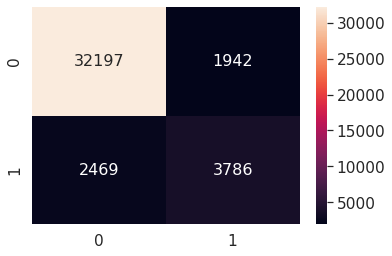

ROC AUC SCORE para la RandomForestClassifier:  0.8834328032462574


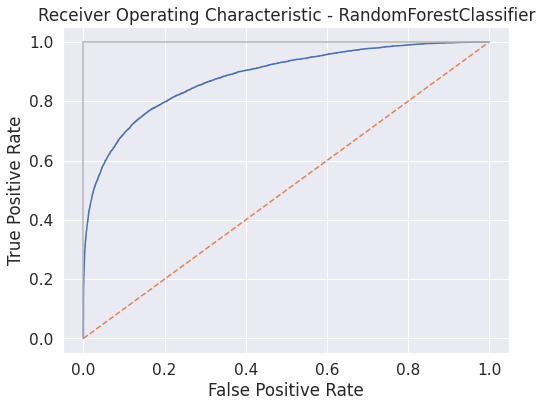

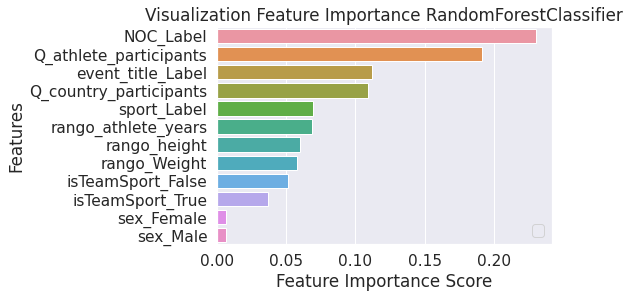


model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9875556449458155, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.340795946107513, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.050812202556880764, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=10,
              max_depth=20, max_leaves=26, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     34139
           1       0.66      0.64      0.65      6255

    accuracy                           0.8

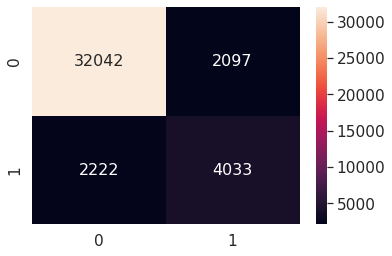

ROC AUC SCORE para la XGB:  0.8950637995710815


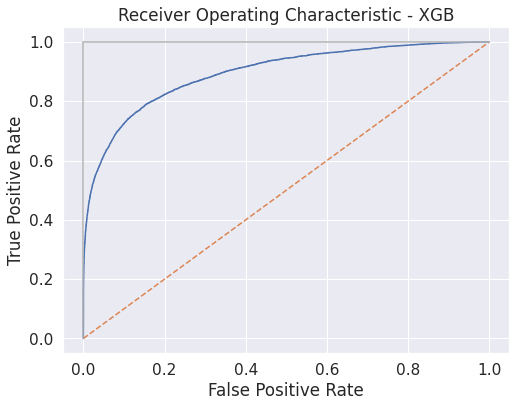

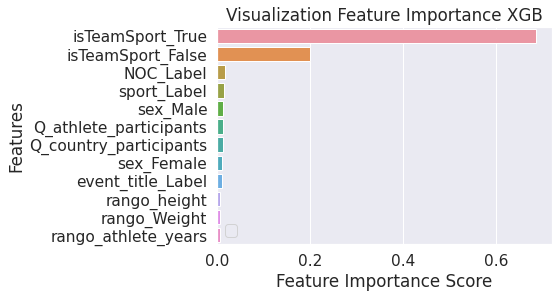

In [ ]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'model: {str(model)}')
    print(classification_report(y_test,y_pred, zero_division=1))
    print('Accuracy: ',accuracy_score(y_test,y_pred), '\n')

# Calcula la matriz de confusión y la muestra en un heatmap
    mc_rl = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(mc_rl, range(2), range(2))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
    plt.show()

# Calcula el score AUC-ROC y lo muestra en una gráfica
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    false_positive_rate, true_positive_rate, treshold = roc_curve(y_test,y_pred_proba)

    print(f'ROC AUC SCORE para la {model_name}: ', roc_auc_score(y_test,y_pred_proba))
    
    plt.subplots(1, figsize=(8,6))
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
# Calcula la importancia de cada característica en el modelo y la muestra en una gráfica
    feature_imp=pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    sns.barplot(x=feature_imp, y= feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(f'Visualization Feature Importance {model_name}')
    plt.legend()
    plt.show()

    column_names = list(feature_imp.index)
    importance_values = list(feature_imp)

    df_importances = pd.DataFrame({'Feature': column_names, 'Importance': importance_values})


    print('='*30, '\n')

In [ ]:
modelo=xgb.XGBClassifier(colsample_bytree= 0.9875556449458155, gamma= 1.340795946107513, learning_rate= 0.050812202556880764, max_delta_step= 10, max_depth= 20, max_leaves= 26, min_child_weight= 0, n_estimators= 130, objective= "binary:logistic", reg_alpha= 0, reg_lambda= 0.8976242441583032, scale_pos_weight= 5.021755954090877, subsample= 0.8190887798896354)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy on training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Predict probabilities on training and test sets
y_train_probs = model.predict_proba(X_train)
y_test_probs = model.predict_proba(X_test)

# Calculate ROC AUC scores on training and test sets
train_roc_auc = roc_auc_score(y_train, y_train_probs[:, 1])
test_roc_auc = roc_auc_score(y_test, y_test_probs[:, 1])

# Compare ROC AUC scores between training and test sets
is_overfitting = train_accuracy > test_accuracy and train_roc_auc > test_roc_auc
percent_diff_ac = (test_accuracy - train_accuracy) / train_accuracy * 100
percent_diff_roc = (test_roc_auc - train_roc_auc) / train_roc_auc * 100

print('train_accuracy:', train_accuracy,
      '\ntest_accuracy:', test_accuracy,
      '\ntrain_roc_auc:', train_roc_auc,
      '\ntest_roc_auc:', test_roc_auc,
      '\npercent_diff_ac:', percent_diff_ac,
      '\npercent_diff_roc:', percent_diff_roc,
      '\nis_overfitting:', is_overfitting)

train_accuracy: 0.9862415131240987 
test_accuracy: 0.893078179927712 
train_roc_auc: 0.9993695835922389 
test_roc_auc: 0.8950637995710815 
percent_diff_ac: -9.446300115807837 
percent_diff_roc: -10.43715815786886 
is_overfitting: True


### PCA y evaluación de modelo

In [ ]:
X = df[['rango_height','Q_athlete_participants','Q_country_participants',"rango_Weight", 'rango_athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = df['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
df2=df.reset_index(drop=True)

In [ ]:
X = df2[['rango_height',"rango_Weight", 'rango_athlete_years', 'event_title_Label', 'sport_Label', "sex_Female"]]

In [ ]:
sc = StandardScaler()
X_stdsc = sc.fit_transform(X)

In [ ]:
X_stdsc

array([[-0.45996488,  1.26292348,  0.94924793,  1.08412253, -0.32359393,
        -0.70787629],
       [-0.45996488,  1.26292348,  0.94924793,  1.09113512, -0.32359393,
        -0.70787629],
       [-0.45996488,  0.22744022,  0.94924793,  1.23489328,  0.94272586,
        -0.70787629],
       ...,
       [ 0.22943544, -0.46288196, -1.47334088,  1.04204697, -1.09972542,
        -0.70787629],
       [ 0.22943544, -0.11772087, -1.12725677, -0.77070838, -1.09972542,
        -0.70787629],
       [ 0.22943544,  1.26292348,  0.94924793,  0.66336694, -1.09972542,
        -0.70787629]])

In [ ]:
pca = PCA()
X_PCA = pca.fit_transform(X_stdsc)

In [ ]:
#Análisis de la varianza explicada para cada componente
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

for i, var in enumerate(cumulative_variance):
    print(f"Component {i+1}: {var:.2f}")

Component 1: 0.39%
Component 2: 0.57%
Component 3: 0.74%
Component 4: 0.88%
Component 5: 0.97%
Component 6: 1.00%


In [ ]:
pca = PCA(n_components = 5)
X_PCA = pca.fit_transform(X_stdsc)

In [ ]:
data=pd.DataFrame(X_PCA,columns=['PCA_' + str(i) for i in range(X_PCA.shape[1])])

In [ ]:
df1=pd.concat([df2,data], axis=1)

In [ ]:
df1.head()

,athlete_id,name,born,height,country,country_noc,medal,event_title,sport,start_date,Q_athlete_participants,Q_country_participants,Year,Weight,posicion,athlete_years,Medal_Bool,Year_1,Games,Event,isTeamSport_False,isTeamSport_True,Edition_Summer Olympics,Edition_Winter Olympics,sex_Female,sex_Male,NOC_Label,event_title_Label,sport_Label,rango_athlete_years,rango_height,rango_Weight,sex,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
0,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Individual, Men",Cycling Road,1912-07-07,123.0,16.0,1912.0,87.0,6.0,28.0,0,1912.0,1912 Summer Olympics,"Cycling Road Road Race, Individual, Men",1,0,1,0,0,1,68,752,26,7,3,8,Male,-1.046807,1.447092,-0.164576,-0.263015,-0.224829
1,16232,Antti Raita,1883-11-15,171.0,Finland,FIN,N_Medal,"Road Race, Team, Men",Cycling Road,1912-07-07,119.0,13.0,1912.0,87.0,5.0,28.0,0,1912.0,1912 Summer Olympics,"Cycling Road Road Race, Team, Men",0,1,1,0,0,1,68,754,26,7,3,8,Male,-1.047389,1.451977,-0.161854,-0.267078,-0.223909
2,43737,Andrzej Socharski,1947-08-31,173.0,Poland,POL,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,72.0,14.0,28.0,0,1976.0,1976 Summer Olympics,"Shooting Skeet, Open",1,0,1,0,0,1,161,795,57,7,3,5,Male,-0.618511,1.367401,0.998406,0.043242,-0.869356
3,42058,Ari Westergård,1948-05-14,170.0,Finland,FIN,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,64.0,22.0,28.0,0,1976.0,1976 Summer Olympics,"Shooting Skeet, Open",1,0,1,0,0,1,68,795,57,7,2,3,Male,0.000505,1.473984,1.006374,0.039635,-1.220873
4,42855,Sandhu Singh Gurbir,1951-02-20,176.0,India,IND,N_Medal,"Skeet, Open",Shooting,1976-07-22,68.0,39.0,1976.0,82.0,56.0,25.0,0,1976.0,1976 Summer Olympics,"Shooting Skeet, Open",1,0,1,0,0,1,93,795,57,5,5,8,Male,-1.528019,0.718437,1.086298,-0.436710,-0.213633


In [ ]:
models= {"XGB":xgb.XGBClassifier(colsample_bytree= 0.9875556449458155, gamma= 1.340795946107513, learning_rate= 0.050812202556880764, max_delta_step= 10, max_depth= 20, max_leaves= 26, min_child_weight= 0, n_estimators= 130, objective= "binary:logistic", reg_alpha= 0, reg_lambda= 0.8976242441583032, scale_pos_weight= 5.021755954090877, subsample= 0.8190887798896354)}

In [ ]:
X = df1[['Q_country_participants',"Q_athlete_participants","isTeamSport_False", 'NOC_Label', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']]
y = df1['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9875556449458155, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.340795946107513, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.050812202556880764, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=10,
              max_depth=20, max_leaves=26, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=130, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     34139
           1       0.63      0.57      0.60      6255

    accuracy                           0.88

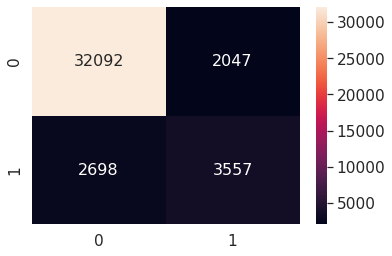

ROC AUC SCORE para la XGB:  0.8647451059920099


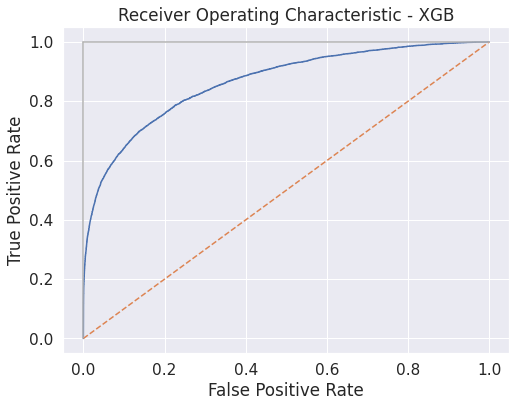

In [ ]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'model: {str(model)}')
    print(classification_report(y_test,y_pred, zero_division=1))
    print('Accuracy: ',accuracy_score(y_test,y_pred), '\n')

    mc_rl = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(mc_rl, range(2), range(2))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
    plt.show()

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    false_positive_rate, true_positive_rate, treshold = roc_curve(y_test,y_pred_proba)

    print(f'ROC AUC SCORE para la {model_name}: ', roc_auc_score(y_test,y_pred_proba))
    
    plt.subplots(1, figsize=(8,6))
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('='*30, '\n')

Dado que ha resultado un f1-score menor aplicando PCA dejaremos de usarlo. Empezaremos a evaluar el modelo con mayor AUC utilizando los hiperparámetros obtenidos.

## Tercera evaluación sobre XGB

Optimizaremos el modelo y evaluaremos:
-	Balanced accuracy
- F1-Score

Esto lo haremos con el dataset que se estaba utilizando ("Normal") y con el dataset modificado con la técnica SMOTE para intentar resolver el desbalance de las clases.

#### Space, hiperparámetro a evaluar y funciones
Aquí se definen valores y funciones que se utilizarán.

In [ ]:
#Listado de hiperparámetros
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 600, 10)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 30, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'gamma': hp.uniform('gamma', 0, 1.5),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 3, 7),
    'objective':  hp.choice('objective', ['binary:logistic']),
    'eval_metric':  hp.choice('eval_metric', ['error', 'logloss',"auc"]),
    'booster':  hp.choice('booster', ['gbtree']),
    'tree_method': hp.choice('tree_method', ['exact']),
    'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
    'max_leaves': scope.int(hp.quniform('max_leaves', 2, 256, 1)),
    'max_bin': scope.int(hp.quniform('max_bin', 2, 512, 1)),
    'min_split_loss': hp.uniform('min_split_loss', 0, 100),
    'sampling_method': hp.choice('sampling_method', ['uniform'])
}

In [ ]:
def parametros(best_hyperparams):
      # Hace una busqueda en space de los mejores hiperparametros obtenidos
    xg = xgb.XGBClassifier(   
        n_estimators= best_hyperparams["n_estimators"],
        max_depth= best_hyperparams["max_depth"],
        learning_rate= best_hyperparams["learning_rate"],
        min_child_weight= best_hyperparams["min_child_weight"],
        subsample= best_hyperparams["subsample"],
        colsample_bytree= best_hyperparams["colsample_bytree"],
        reg_alpha= best_hyperparams["reg_alpha"],
        reg_lambda= best_hyperparams["reg_lambda"],
        gamma= best_hyperparams["gamma"],
        scale_pos_weight= best_hyperparams["scale_pos_weight"],
        max_leaves= best_hyperparams["max_leaves"],
        objective=  best_hyperparams["objective"],
        eval_metric=  best_hyperparams["eval_metric"],
        booster=  best_hyperparams["booster"],
        tree_method= best_hyperparams["tree_method"],
        grow_policy= best_hyperparams["grow_policy"],
        max_bin= best_hyperparams["max_bin"],
        min_split_loss= best_hyperparams["min_split_loss"],
        sampling_method= best_hyperparams["sampling_method"])
    return xg

In [ ]:
X = df[['rango_height','Q_athlete_participants','Q_country_participants',"rango_Weight", 'rango_athlete_years','isTeamSport_False','isTeamSport_True', 'sex_Female','sex_Male', 'NOC_Label', 'event_title_Label', 'sport_Label']]
y = df['Medal_Bool']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
def overfitting(xg,X_train,X_test,y_train,y_teest):
    """
    Evalúa si un modelo de clasificación representado por el objeto `xg` está sobreajustando o no.

    Args:
        xg: Modelo de clasificación XGBoost.
        X_train: Datos de entrenamiento.
        X_test: Datos de prueba.
        y_train: Datos de entrenamiento.
        y_test: Datos de prueba.

    Returns:
        Un diccionario con las siguientes claves y valores:
        - 'train_accuracy': La precisión del modelo en el conjunto de entrenamiento.
        - 'test_accuracy': La precisión del modelo en el conjunto de prueba.
        - 'train_roc_auc': La puntuación ROC AUC del modelo en el conjunto de entrenamiento.
        - 'test_roc_auc': La puntuación ROC AUC del modelo en el conjunto de prueba.
        - 'percent_diff_ac': La diferencia porcentual entre la precisión del conjunto de prueba y la precisión del conjunto de entrenamiento.
        - 'percent_diff_roc': La diferencia porcentual entre la puntuación ROC AUC del conjunto de prueba y la puntuación ROC AUC del conjunto de entrenamiento.
        - 'is_overfitting': Un indicador booleano de si el modelo está sobreajustando o no. True si el modelo está sobreajustando, False de lo contrario.
    """
    y_train_pred = xg.predict(X_tr)
    y_test_pred = xg.predict(X_te)

        # Calculate accuracy on training and test sets
    train_accuracy = accuracy_score(y_tr, y_train_pred)
    test_accuracy = accuracy_score(y_te, y_test_pred)
    
        # Predict probabilities on training and test sets
    y_train_probs = xg.predict_proba(X_tr)
    y_test_probs = xg.predict_proba(X_te)

    # Calculate ROC AUC scores on training and test sets
    train_roc_auc = roc_auc_score(y_tr, y_train_probs[:, 1])
    test_roc_auc = roc_auc_score(y_te, y_test_probs[:, 1])

    # Compare ROC AUC scores between training and test sets
    is_overfitting = train_accuracy > test_accuracy and train_roc_auc > test_roc_auc
    percent_diff_ac = (test_accuracy - train_accuracy) / train_accuracy * 100
    percent_diff_roc = (test_roc_auc - train_roc_auc) / train_roc_auc * 100
    
    # Devolver un diccionario con las métricas y el indicador de sobreajuste
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_roc_auc': train_roc_auc,
        'test_roc_auc': test_roc_auc,
        'percent_diff_ac': percent_diff_ac,
        'percent_diff_roc': percent_diff_roc,
        'is_overfitting': is_overfitting
    }

### Normal

In [ ]:
def objective(params):
      """
    Función objetivo para la optimización de hiperparámetros de un clasificador XGBoost utilizando 
    la biblioteca de optimización de hiperparámetros Hyperopt.

    Args:
        params: Un diccionario de hiperparámetros para el clasificador XGBoost.

    Returns:
        Un diccionario con dos claves:
        - 'loss': El valor negativo de la puntuación de precisión equilibrada obtenida por cross-validation 
        del clasificador XGBoost entrenado en el conjunto de entrenamiento.
        - 'status': El estado de la optimización, que debe ser 'STATUS_OK' si la función se completó con éxito.
    """
    clf = xgb.XGBClassifier(**params, n_jobs=9, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    balanced_accuracy = cross_val_score(clf, X_train, y_train, cv=cv, scoring='balanced_accuracy').mean()
    return {'loss': -balanced_accuracy, 'status': STATUS_OK}


trials = Trials()
result = fmin(objective, space, algo=tpe.suggest, max_evals=100,trials=trials)
score = -trials.best_trial['result']['loss']
print(f"Score: {score:.4f}")
best_result = result
best_hyperparams = space_eval(space, best_result)
print(best_hyperparams)

#Imprime Reporte   
xg = parametros(best_hyperparams)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
bal_acc=balanced_accuracy_score(y_test,y_pred)
print(f'XGB (bal_acc={bal_acc:.2f})')
print(classification_report(y_test,y_pred, zero_division=1))

#Imprime matrix de confusión 
mc_rl = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(mc_rl, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
plt.show()

print(overfitting(xg, X_train,X_test,y_train,y_test))

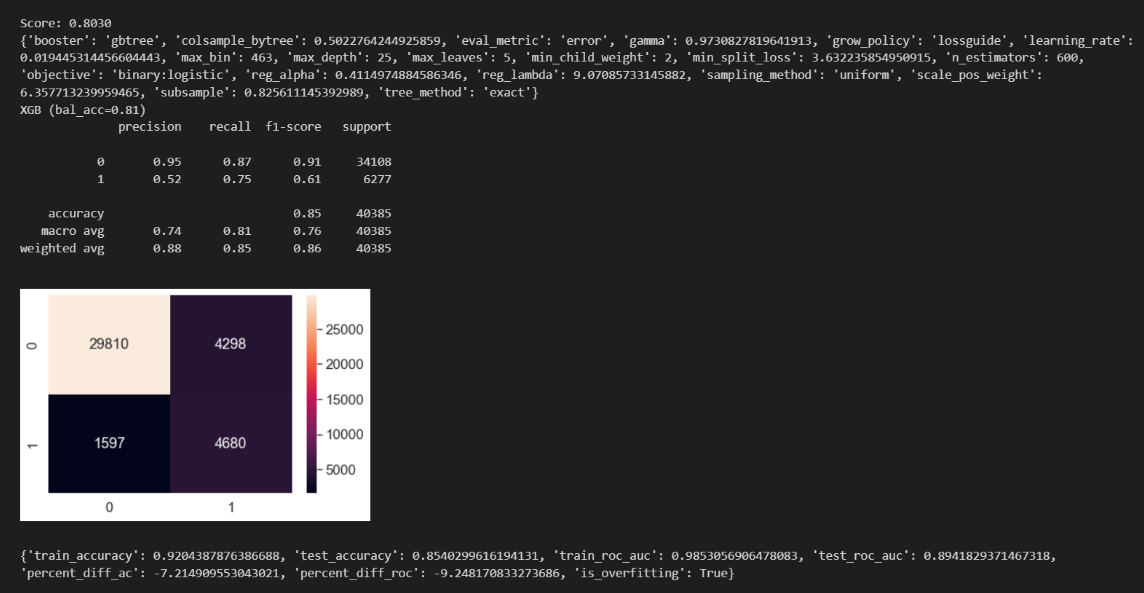

In [ ]:
def objective(params):
      """
    Función objetivo para la optimización de hiperparámetros de un clasificador XGBoost utilizando 
    la biblioteca de optimización de hiperparámetros Hyperopt.

    Args:
        params: Un diccionario de hiperparámetros para el clasificador XGBoost.

    Returns:
        Un diccionario con dos claves:
        - 'loss': El valor negativo de la puntuación de F1 Score obtenida por cross-validation 
        del clasificador XGBoost entrenado en el conjunto de entrenamiento.
        - 'status': El estado de la optimización, que debe ser 'STATUS_OK' si la función se completó con éxito.
    """
    clf = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1').mean()
    return {'loss': -f1, 'status': STATUS_OK}


trials = Trials()
result = fmin(objective, space, algo=tpe.suggest, max_evals=100,trials=trials)
score = -trials.best_trial['result']['loss']
print(f"- Score: {score:.4f}")
best_result = result
best_hyperparams = space_eval(space, best_result)
print(best_hyperparams)

#Imprime Reporte   
xg = parametros(best_hyperparams)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
bal_acc=balanced_accuracy_score(y_test,y_pred)
print(f'XGB (bal_acc={bal_acc:.2f})')
print(classification_report(y_test,y_pred, zero_division=1))

#Imprime matrix de confusión 
mc_rl = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(mc_rl, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
plt.show()

print(overfitting(xg, X_train,X_test,y_train,y_test))

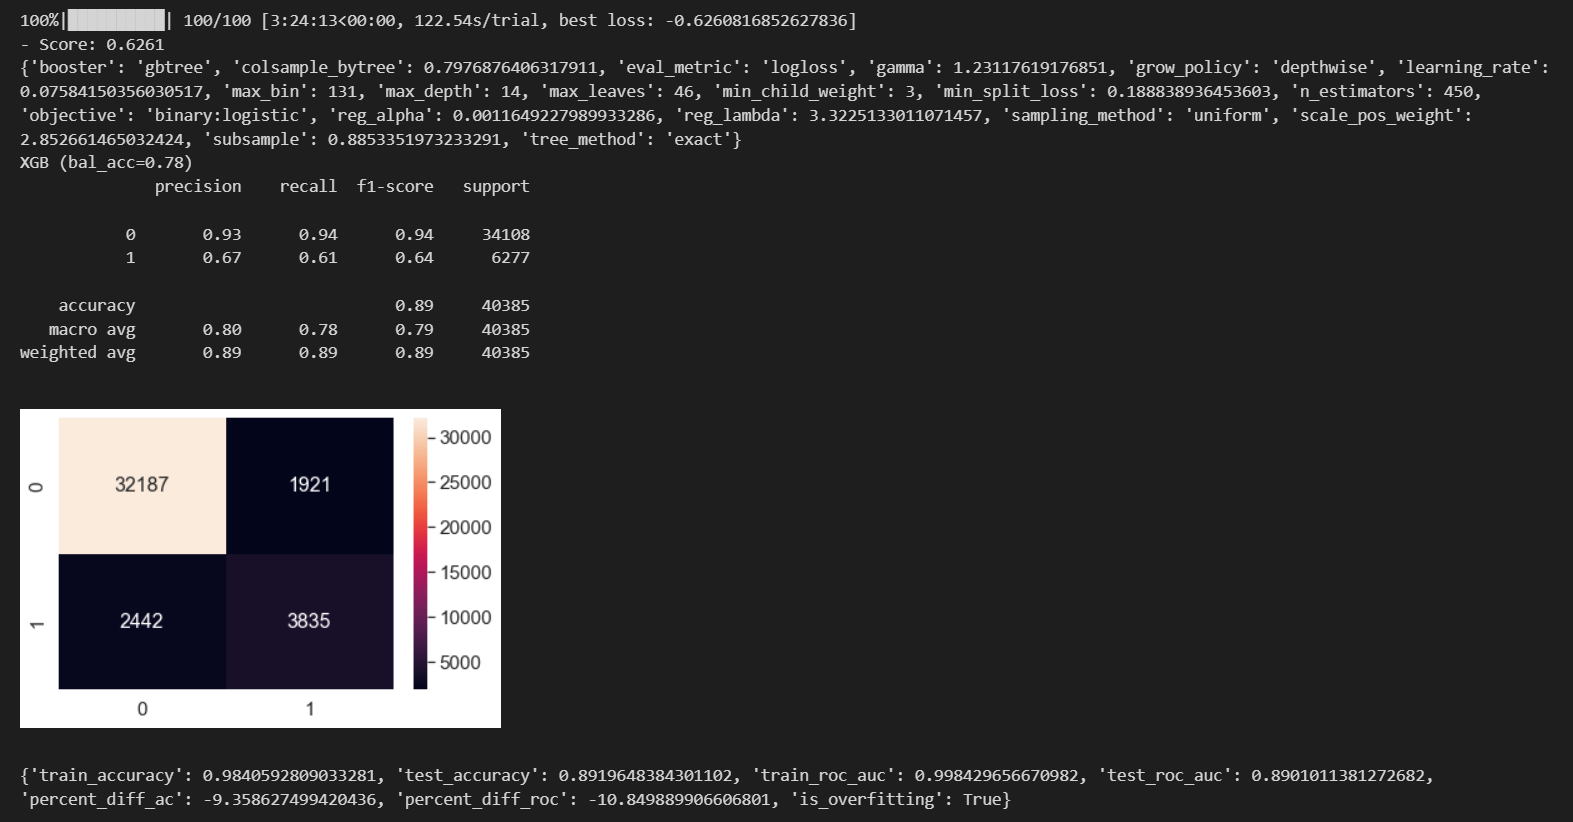

### SMOTE
Este algoritmo combina oversampling y undersampling.

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

def objective(params):
    clf = xgb.XGBClassifier(**params, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    balanced_acc = cross_val_score(clf, X_train, y_train, cv=cv, scoring='balanced_accuracy').mean()
    return {'loss': -balanced_acc, 'status': STATUS_OK}

trials = Trials()
result = fmin(objective, space, algo=tpe.suggest, max_evals=100,trials=trials)
score = -trials.best_trial['result']['loss']
print(f"Score: {score:.4f}")

best_result = result
best_hyperparams = space_eval(space, best_result)
print(best_hyperparams)

#Imprime Reporte   
xg = parametros(best_hyperparams)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
bal_acc=balanced_accuracy_score(y_test,y_pred)
print(f'XGB (bal_acc={bal_acc:.2f})')
print(classification_report(y_test,y_pred, zero_division=1))

#Imprimr matrix de confuision 
mc_rl = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(mc_rl, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
plt.show()

print(overfitting(xg, X_train,X_test,y_train,y_test))


```
100%|██████████| 100/100 [8:06:19<00:00, 291.79s/trial, best loss: -0.9302561544644604] 
Score: 0.9303

`{'booster': 'gbtree', 'colsample_bytree': 0.9280537716802075, 'eval_metric': 'error', 'gamma': 1.0668156367633206, 'grow_policy': 'lossguide', 'learning_rate': 0.18046431620182798, 'max_bin': 345, 'max_depth': 19, 'max_leaves': 133, 'min_child_weight': 2, 'min_split_loss': 0.0934248619199275, 'n_estimators': 390, 'objective': 'binary:logistic', 'reg_alpha': 0.8469792566557013, 'reg_lambda': 5.729820570154878, 'sampling_method': 'uniform', 'scale_pos_weight': 4.520807046751701, 'subsample': 0.66698108492173, 'tree_method': 'exact'}`
XGB (bal_acc=0.94)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     34098
           1       0.92      0.95      0.94     34115

    accuracy                           0.94     68213
   macro avg       0.94      0.94      0.94     68213
weighted avg       0.94      0.94      0.94     68213

{'train_accuracy': 0.9927029770827301, 'test_accuracy': 0.9356427660416636, 'train_roc_auc': 0.9997815666164424, 'test_roc_auc': 0.9830467671928402, 'percent_diff_ac': -5.7479641300915745, 'percent_diff_roc': -1.6738455661107705, 'is_overfitting': True}


```


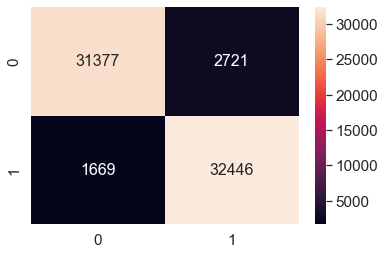


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)
def objective(params):
    clf = xgb.XGBClassifier(**params, n_jobs=9, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1').mean()
    return {'loss': -f1, 'status': STATUS_OK}

trials = Trials()
result = fmin(objective, space, algo=tpe.suggest, max_evals=100,trials=trials)
score = -trials.best_trial['result']['loss']
print(f"Score: {score:.4f}")

best_result = result
best_hyperparams = space_eval(space, best_result)
print(best_hyperparams)

#Imprime Reporte   
xg = parametros(best_hyperparams)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
bal_acc=balanced_accuracy_score(y_test,y_pred)
print(f'XGB (bal_acc={bal_acc:.2f})')
print(classification_report(y_test,y_pred, zero_division=1))

#Imprimr matrix de confuision 
mc_rl = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(mc_rl, range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
plt.show()

print(overfitting(xg, X_train,X_test,y_train,y_test))


```

100%|██████████| 100/100 [10:39:46<00:00, 383.86s/trial, best loss: -0.9294109622074707] 
Score: 0.9294
{'booster': 'gbtree', 'colsample_bytree': 0.7378755662012754, 'eval_metric': 'auc', 'gamma': 0.5812702101573388, 'grow_policy': 'depthwise', 'learning_rate': 0.13964708030597683, 'max_bin': 369, 'max_depth': 27, 'max_leaves': 2, 'min_child_weight': 3, 'min_split_loss': 0.2805290610631186, 'n_estimators': 520, 'objective': 'binary:logistic', 'reg_alpha': 3.868697170765752, 'reg_lambda': 5.771743241855665, 'sampling_method': 'uniform', 'scale_pos_weight': 3.0232322299628627, 'subsample': 0.883933257168687, 'tree_method': 'exact'}
XGB (bal_acc=0.93)
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     34098
           1       0.92      0.95      0.93     34115

    accuracy                           0.93     68213
   macro avg       0.93      0.93      0.93     68213
weighted avg       0.93      0.93      0.93     68213

{'train_accuracy': 0.9837273823442099, 'test_accuracy': 0.9337223109964377, 'train_roc_auc': 0.9990407664873479, 'test_roc_auc': 0.9823487425055766, 'percent_diff_ac': -5.083224503582564, 'percent_diff_roc': -1.6708050904129614, 'is_overfitting': True}

```

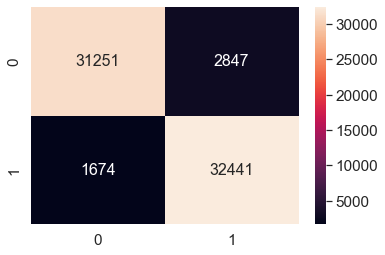

# Conclusiones




*   A pesar de haber realizado un extenso trabajo analítico, los modelos obtenidos no performaron a la calidad esperada.
*   Los factores que más contribuyeron a la predicción no fueron los esperados.
*   A pesar de contar con un dataset muy extenso, es muy heterogéneo, con variedad de deportes, contexturas físicas que además fueron variando con los años.
*   No parece haber relaciones estrechas entre el peso, la altura, la edad y la obtención de medallas.

Entre los factores que más contribuyen a las predicciones se encuentran: el país que representan, si es un deporte de equipo o no y la cantidad de atletas que participan.

*¿Cómo se explica esto?*

Tomemos el ejemplo del básquetbol. Este es un deporte dominado por Estados Unidos. Solo 3 veces desde 1936 no ganaron la medalla de oro, y en esos casos obtuvieron medallas de plata y bronce. Por lo tanto, si un atleta, es basquetbolista (deporte de equipo) y es estadounidense, es altamente probable que gane la medalla dorada. 

Esta situación se repite en varios deportes: Jamaica en velocidad, Cuba en boxeo, Fiji en rugby, y muchos más. Esta es la razón por la cual el país es más importante que el peso, la altura y la edad.

Otro campos que no determina nada es el sexo. La gran mayoría de las disciplinas están separadas por sexo lo que anula las diferencias. Y en aquellas pocas en las que es un equipo mixto donde no parece tener inferencia.

A pesar de no haber obtenido modelos que predigan con exactitud quiénes recibirán una medalla, podemos obtener un aprendizaje importante a partir de esto: los altetas ganadores son más que solo su cuerpo. No es la edad, ni la altura, ni el peso por si solos lo que determina el éxito. Deberíamos obtener datos sobre las horas de entrenamiento, las horas de análisis de video, las horas de kinesiología y viajes que cada atleta realiza para tener un panorama más completo sobre la formación de los campeones. 